Simulate a joints with different divergences from a "smooth" motion.

In [2]:
# Set the folder where all (temporary) files and folders will be saved

# Do everything form scratch
data_folder = './data/'

periodicity = 25
number_steps = 200
limit_plot = 50
overwrite = False
redo = False

do_image_plots = True

# or use the donwloaded data
data_folder = 'data_1000'
url = 'https://www.dropbox.com/s/4fo6jp790of9vgx/knee_joints_54e707d.zip?dl=1'

## used settings
# periodicity = 100
# number_steps = 1000
# limit_plot = 1000
# overwrite = False
# redo = False

# do_image_plots = True

In [3]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    ## just the python file
    # !wget -O data.zip https://www.dropbox.com/s/s3r30usguzkk362/knee_joints.py.zip?dl=0
    # !unzip data.zip -d ./

    !wget -O data.zip {url}
    !unzip data.zip -d ./

    !pip install gudhi
    !apt install imagemagick

    # fix the "can't load if picke_allow=False" error in colab
    import numpy as np
    # save np.load
    np_load_old = np.load
    # modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

else:
    import urllib.request
    import shutil
    from zipfile import ZipFile
    import os
    
    if os.path.isdir(data_folder):
        print("Folder {data_folder} already exists! Didn't download and extract!")
        print("Delete folder and rerun cell if want to re-download etc.!")
    else:
        print('Downloading zip file')
        filename = 'data_temporary.zip'
        urllib.request.urlretrieve(url, filename)

        print('Extracting zip file')
        with ZipFile('./data_temporary.zip', 'r') as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall('data_temporary')

        print('Moving to right folder')
        if os.path.isdir(f'./data_temporary/{data_folder}'):
            shutil.move(f'./data_temporary/{data_folder}', './')
            shutil.rmtree('./data_temporary/')
        else:
            print("Folder {data_folder} has not been found in the unzipped folder!")

Folder {data_folder} already exists! Didn't download and extract!
Delete folder and rerun cell if want to re-download etc.!


In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as skio
import pandas as pd

import subprocess
import os
from pathlib import Path
import sys

from tqdm import tqdm
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding

from knee_joints import Knee_Joints, Joints
from knee_joints import create_fig, diagram_convert, get_distance_matrix, get_max_pw_dist

from gudhi import bottleneck_distance
from gudhi.hera import wasserstein_distance
from gudhi.representations import Landscape, Entropy
from gudhi.representations.preprocessing import DiagramSelector

## Set UP

Import the necessary modules

Create the necessary folders if the data is not given yet

In [4]:
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

create_folders = ['animation', 'arrays', 'distances', 'images', 'plots', 
                  'tmp_files', 'persistence_diagrams']
for cr_folder in create_folders:
    folderpath = os.path.join(data_folder, cr_folder)
    if not os.path.isdir(folderpath):
        print('Created folder', folderpath)
        os.mkdir(folderpath)

## Simulating joints

Simulate the knee and several joints and save the results as images as well as coordinate matrices of the joints.

In [5]:
periodicity = 100
number_steps = 1000
limit_plot = 1000
overwrite = False
redo = False

do_image_plots = True

params = {'folder': -1,
          'move_method': -1,
          'noise': 0,
          'bandwidth': 0,
          'time_updater': 1}

samples = [{'folder': 'images_smooth',
            'move_method': 'sinoidal'},
           # quicker pace
           {'folder': 'images_smooth_quick',
            'move_method': 'sinoidal',
            'time_updater': 5},
            # {'folder': 'images_smooth_quick',
            # 'move_method': 'sinoidal',
            # 'time_updater': 20},
           # noisy
           {'folder': 'images_noisy',
            'move_method': 'sinoidal_noise',
            'noise': 0.01},
           {'folder': 'images_noisy',
            'move_method': 'sinoidal_noise',
            'noise': 0.1},
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0,
            'bandwidth': 0.1},
           # last point
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0.1,
            'bandwidth': 0.1},
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0.01,
            'bandwidth': 0.1},
           # skip
           {'folder': 'images_skip',
            'move_method': 'skip_overextension',
            'noise': 0,
            'bandwidth': 0.1},
           {'folder': 'images_skip',
            'move_method': 'skip_overextension',
            'noise': 0.1,
            'bandwidth': 0.1}
           ]

Perfom the simulation of the joints and save the resulting figures in the appropriate subfolder in `images` and the resulting array of x,y coordinates of each joint in `arrays`.

In this example the joints are:

> `kj = Knee_Joints(number_steps=periodicity)` 
> `kj.add_point_relative(xborder=[-0.25, 0.25])`
> `kj.add_point_relative(xborder=[-0.5, 0.5])`
> `kj.add_point_relative(xborder=[-1, 1])`

In [6]:
samples_pts = []
pbar = tqdm(samples)
# for folder, move_method, noise, bandwidth in pbar:
for sample in pbar:
    for i, key in enumerate(params):
        if key not in sample:
            if params[key] == -1:
                raise ValueError(f'{key} needs to be set!')
            else:
                sample[key] = params[key]

    # TODO need to copy these into the fields below
    folder = sample['folder']
    move_method = sample['move_method']
    noise = sample['noise']
    bandwidth = sample['bandwidth']
    time_updater = sample['time_updater']

    # find the right folder name and filename
    if noise > 0:
        folder = f'{folder}_{noise}'

    # if we have no noise and overwrite is not True take the next one
    if (((noise == 0 and not overwrite) or (not redo))
       and os.path.isdir(os.path.join(data_folder, 'images', folder))
       and os.path.isfile(os.path.join(data_folder, 'arrays', f'{folder}.npy'))):

        print(f'  {folder} exists already, skip')
        continue

    found_folder = False
    step = 1
    folder_loop = folder
    while not found_folder:
        if not os.path.isdir(os.path.join(data_folder, 'images', folder_loop)):
            os.mkdir(os.path.join(data_folder, 'images', folder_loop))
            found_folder = True
        elif not overwrite and os.path.isfile(os.path.join(data_folder, 'images', 
                                                           f'{folder_loop}.npy')):
            folder_loop = f'{folder}_{step}'
            step += 1
        else:
            found_folder = True
    folder = folder_loop

    # update progressbar
    pbar.set_description(f'processing: {folder}')


    ##### CREATION OF THE CONSTRUCT; SAME BASELINE FOR ALL OF THEM
    # construct the knee joint
    kj = Knee_Joints(number_steps=periodicity)
    kj.add_point_relative(xborder=[-0.25, 0.25])
    kj.add_point_relative(xborder=[-0.5, 0.5])
    kj.add_point_relative(xborder=[-1, 1])

    kj.save_current()

    for move in range(number_steps - 1):
        kj.move_joint(method=move_method,
                      noise_size=noise,
                      bandwidth=bandwidth, 
                      time_updater=time_updater)

    points = kj.get_history_array()
    np.save(os.path.join(data_folder, 'arrays', f'{folder}.npy'), points)
    samples_pts.append(points)

    if do_image_plots:
        n_joints = len(kj.points)
        bbox = kj.get_bounding_box()

        for j, points in enumerate(kj.history):
            if j >= limit_plot:
                break
            fig, ax = plt.subplots(1, 1, dpi=200)
            G = nx.Graph()

            keys = list(points.keys())
            G.add_nodes_from(keys)
            G.add_edges_from([(keys[i], keys[i+1])
                            for i in range(len(keys)-1)])

            pos = [points[key] for key in keys]
            nx.draw(G, pos, ax=ax)
            # ax.set_title(' '.join(folder.split('_')[1:]))
            ax.set_xlim(left=bbox[0]-1, right=bbox[1]+1)
            ax.set_ylim(bottom=bbox[2]-1, top=bbox[3]+1)

            fig.savefig(os.path.join(data_folder, 'images', 
                                     f'{folder}/movement_{j:04d}.png'))
            plt.close(fig)

100%|██████████| 9/9 [00:00<00:00, 4496.04it/s]

  images_smooth exists already, skip
  images_smooth_quick exists already, skip
  images_noisy_0.01 exists already, skip
  images_noisy_0.1 exists already, skip
  images_last-point exists already, skip
  images_last-point_0.1 exists already, skip
  images_last-point_0.01 exists already, skip
  images_skip exists already, skip
  images_skip_0.1 exists already, skip


# GIF creation
Get the folder for which images and arrays were created and create the gif if the file doesn't already exist.

Problems can be:
- is the current command the legacy `convert` or is it `magick`; in windows it clashes e.g. with the filetype converted between NTFS and FAT; hence use magick for windows?
- !!!the syntax is slighlty different for different versions of imagemagick!! (here it's v7)
- for windows we need double quotes, single quotes are not recognised right.
- how does imagemagick do it when adding different sized gif ones?
- what's the right height for the text?
- more?

TODO: USE `wand` in python as an interface for imagemagick!

In [57]:
if os.name == 'nt':
    call_img_mag = 'magick'
else:
    call_img_mag = 'convert'

if RunningInCOLAB:
    !convert --version >> image_magick_version.txt
else:
  open('image_magick_version.txt', 'w').close()
  subprocess.call([call_img_mag, '--version'], stdout=open('image_magick_version.txt', 'w'))

with open('image_magick_version.txt') as file:
  img_magick_7 = False
  for fn in file:
    if 'Version: ImageMagick 7' in fn:
      img_magick_7 = True
      break
os.remove('image_magick_version.txt')
print('Image magick has version 7?', img_magick_7)

Image magick has version 7? True


In [4]:
folders = []
for item in Path(f'./{data_folder}/images').iterdir():
    if (item.is_dir()
       and str(item.name).startswith('images_')):
        # if not os.path.isfile(os.path.join('arrays', f'{item.name}.npy')):
        #     print(f"  {item.name} doesn't have an associated array!")
        # else:
        folders.append(item.name)
folders.sort()
if 'images_smooth' in folders:
    folders.remove('images_smooth')
    folders.insert(0, 'images_smooth')

folders

['images_smooth',
 'images_last-point',
 'images_last-point_0.01',
 'images_last-point_0.1',
 'images_noisy_0.01',
 'images_noisy_0.1',
 'images_skip',
 'images_skip_0.1',
 'images_smooth_quick']

Let us just get the gif for each image series as separate .gif files

In [64]:
# get the gifs for each image series and resize them
file_error = 'error_log_individual_gif_creation.txt'

pbar = tqdm(folders)
for folder in pbar:
    if not os.path.isfile(f'./{data_folder}/animation/anim_{folder}.gif'):
        pbar.set_description(f'processing: {folder}')
        if img_magick_7:
            # imagemagick 7 syntax
            call = [call_img_mag,
                    f'./{data_folder}/images/{folder}/*.png',
                    '-scale', '50%', '-delay', '10', '-loop', '0',
                    f'./{data_folder}/animation/anim_{folder}.gif']
        else:
            call = [call_img_mag,
                    '-scale', '50%', '-delay', '10', '-loop', '0',
                    f'./{data_folder}/images/{folder}/*.png',
                    f'./{data_folder}/animation/anim_{folder}.gif']
        
        # now call the imagemagick conversion and plot the error message
        # if there is one
        subprocess.call(call, stderr=open(file_error, 'w'))

        with open(file_error, 'r') as file:
            fn = file.read()
            if len(fn) > 0:
                print(f'Error in {folder}:')
                print(fn)

if os.path.isfile(file_error):
    os.remove(file_error)

100%|██████████| 9/9 [00:00<00:00, 8989.93it/s]


Append images - we assume a 3x3 grid - and then create a gif joining all of them together in the end.

THIS TAKES A LONG TIME depending on the number of images! Hence we commented it out - in particular due to the problems with imagemagick versions, which is NOT handled here!

In [33]:
# # append all images first
# # assume we have 9 different image_sequences

# filenames = []
# for folder in folders:
#     fn_tmp = os.listdir(f'./{data_folder}/images/{folder}/')
#     fn_tmp.sort()
#     fn_tmp = [x.split('_')[1].split('.')[0] for x in fn_tmp 
#               if x.startswith('movement') and x.endswith('.png')]
#     filenames.append(fn_tmp)

# # check if all image folders are of the same size
# assert all([len(x)==len(filenames[0]) for x in filenames])

# # check if all filenames on the same level are the same
# assert all([len(x[i])==len(filenames[0][i])
#             for i in range(len(filenames[0]))
#             for x in filenames])

# # now we can just take the first list entry
# filenames = filenames[0]

In [45]:
# # file name for temporary error log
# file_error = 'file_append_images.txt'

# dest = os.path.join('.', data_folder, 'tmp_files', 'appended_images')
# if not os.path.isdir(dest):
#     print('Created folder:', dest)
#     os.mkdir(dest)

# # now append the files
# for x in tqdm(filenames):
#     if os.name == 'nt':
#         p_open = '('
#         p_close = ')'
#     else:
#         # for unix the command is convert and parenthesis
#         # have to be escaped
#         p_open = '\('
#         p_close = '\)'
    
#     call = [call_img_mag]
#     col_i = 0
#     for folder in folders:
        
#         annotate = ' '.join(folder.split('_')[1:])
#         if col_i % 3 == 0:
#             call.extend([p_open])
        
#         call.extend([p_open, f'./{data_folder}/images/{folder}/movement_{x}.png', 
#                     '-gravity', 'North', '-pointsize', '30', '-annotate', '+0+50', f'{annotate}', p_close
#                     ])

#         if col_i % 3 == 2:
#             call.extend(['+append', p_close,])
        
#         if col_i == 8:
#             call.extend(['-background', 'none', '-append',
#                          f'./{data_folder}/tmp_files/appended_images/append_{x}.png'])
#         col_i += 1
    
#     if os.path.isdir(os.path.join(os.path.split('/')[:-1])):
#         subprocess.call(call, stderr=open(file_error, 'w'))

#         with open(file_error, 'r') as file:
#             fn = file.read()
#             if len(fn) > 0:
#                 print(f'Error in {folder}:')
#                 print(fn)
#     else:
#         print('Not a directory: ', os.path.join(os.path.split(call[-1])[:-1]))
#         break

# if os.path.isfile(file_error):
#     os.remove(file_error)

100%|██████████| 1000/1000 [29:19<00:00,  1.76s/it]


In [59]:
# # file name for temporary error log
# file_error = 'file_append_images.txt'

# call = [call_img_mag, 
#         f'./{data_folder}/tmp_files/appended_images/append_*.gif',
#         '-scale', '50%', '-delay', '10', '-loop', '0',
#         f'./{data_folder}/animation/anim_all.gif']
# subprocess.call(call, stderr=open(file_error, 'w'))

# with open(file_error, 'r') as file:
#     fn = file.read()
#     if len(fn) > 0:
#         print(f'Error in {folder}:')
#         print(fn)

# if os.path.isfile(file_error):
#     os.remove(file_error)

0

# Persistence computation

Calculate the persistence for the different combinations. 
Plot the different steps later.

In [8]:
# get the folders

folders = []
for item in Path(data_folder, 'arrays').iterdir():
    if (str(item.name).startswith('images_')
       and str(item.name).endswith('.npy')):
        folders.append(item.name)

# sort folders and put 'images_smooth' in 
# first position if it exists
folders.sort()
if 'images_smooth.npy' in folders:
    folders.remove('images_smooth.npy')
    folders.insert(0, 'images_smooth.npy')

samples_all = [(i,
                '_'.join(folders[i].split('_')[1:]),
                np.load(os.path.join(data_folder, 'arrays', f'{folders[i]}')))
               for i in range(len(folders))]

folders = [folder[:-4] for folder in folders]

### Coordinate distance and its persistence

Get the pairwise distances using the coordinates of the joints as basis:

In [9]:
if os.path.isfile(os.path.join(data_folder, 'distances', 'distances_coords.npz')):
    distances = np.load(os.path.join(data_folder, 'distances',
                                     'distances_coords.npz'))
    distances = distances['distances']
else:
    distances = []
    for k, txt, points_plot in samples_all:
        dist_mat = np.zeros([len(points_plot), len(points_plot)])
        for i in range(len(points_plot)):
            for j in range(i+1, len(points_plot)):
                dist_mat[i, j] = np.linalg.norm(points_plot[i] - points_plot[j])
                dist_mat[j, i] = dist_mat[i, j]
            
        distances.append(dist_mat)

    distances = np.array(distances)
    np.savez_compressed(os.path.join(data_folder, 'distances', 'distances_coords.npz'), 
                        names=[folder for folder in folders],
                        distances=distances)

Difference of consecutive points

In [10]:
l2_coords = []
for _, _, points_plot in samples_all:
    l2_coords.append([np.linalg.norm(points_plot[i+1] - points_plot[i])
                      for i in range(points_plot.shape[0]-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2_coords)

Alpha complex and Vietoris Rips complex computation for consecutive distances

In [11]:
if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_alphacomplex.npz')):
    arr_dgm = []
    for i in range(len(pc_taken)):
        acX = gd.AlphaComplex(points=pc_taken[i]).create_simplex_tree()
        dgmX = acX.persistence()
        arr_dgm.append(diagram_convert(dgmX))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_alphacomplex.npz'), **tmp_dict)

In [12]:
# this can take a while, hence save the intermediate results
# on my machine ~ 1.40min per iteration

if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_VRcomplex.npz')):
    for i in tqdm(range(len(pc_taken))):
        if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy')):
            acX = gd.RipsComplex(points=pc_taken[i]).create_simplex_tree(max_dimension=2)
            dgmX = acX.persistence()
            np.save(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy'), diagram_convert(dgmX))

    arr_dgm = []
    for i in tqdm(range(len(pc_taken))):
        arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy')))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'coords_consecutive_VRcomplex.npz'), **tmp_dict)


for i in tqdm(range(len(pc_taken))):
    if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy')):
        print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy'))
        os.remove(os.path.join(data_folder, 'tmp_files', f'vr_coords_{i}.npy'))

100%|██████████| 9/9 [00:00<00:00, 8992.08it/s]


In [13]:
# this can take a while, hence save the intermediate results
# on my machine ~ 1.30min per iteration

if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'coords_distmatrix_VRcomplex.npz')):
    for i in tqdm(range(len(distances))):
        if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy')):
            acX = gd.RipsComplex(distance_matrix=distances[i]).create_simplex_tree(max_dimension=2)
            dgmX = acX.persistence()
            np.save(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy'), diagram_convert(dgmX))

    arr_dgm = []
    for i in tqdm(range(len(pc_taken))):
        arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy')))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'coords_distmatrix_VRcomplex.npz'), **tmp_dict)


for i in tqdm(range(len(pc_taken))):
    if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy')):
        print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy'))
        os.remove(os.path.join(data_folder, 'tmp_files', f'vr_coords_dist_{i}.npy'))

100%|██████████| 9/9 [00:00<00:00, 8992.08it/s]


### image distance

Now we use the distances of the images as input in the alpha and vietoris rips complexes

Get the pairwise distances of the images as matrices:

In [14]:
if os.path.isfile(os.path.join(data_folder, 'distances', 'distances_images.npz')):
    distances_images = np.load(os.path.join(data_folder, 'distances', 'distances_images.npz'))
    names = distances_images['names']
    distances_images = distances_images['distances']
else:
    distances_images = []
    for folder in folders:
        files = os.listdir(os.path.join(data_folder, f'images/{folder}'))
        files.sort()

        print(folder)
        print(' - Read in images')
        images = []
        for file in tqdm(files):
            filepath = os.path.join(data_folder, f'images/{folder}/{file}')
            if filepath.startswith('movement_'): 
                img = skio.imread(filepath)[:, :, :3]
            img = np.uint8(rgb2gray(img))
            images.append(np.array(img < 1, dtype=np.int32))

        print(' - Create distance matrix')
        dist_mat = np.zeros([len(images), len(images)])
        for i in tqdm(range(len(images))):
            for j in range(i+1, len(images)):
                dist_mat[i, j] = np.linalg.norm(images[i] - images[j])
                dist_mat[j, i] = dist_mat[i, j]
            
        distances_images.append(dist_mat)

    distances_images = np.array(distances_images)
    np.savez_compressed(os.path.join(data_folder, 'distances', 'distances_images.npz'),
                        names=[folder for folder in folders],
                        distances=distances_images)

In [15]:
# Get the difference of consecutive images
l2_images = []
for k, _ in enumerate(folders):
    l2_images.append([np.linalg.norm(distances_images[k][i+1, i])
               for i in range(len(distances_images[k])-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2_images)

Alpha complex complex computation for consecutive distances

In [16]:
if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_alphacomplex.npz')):
    arr_dgm = []
    for i in range(len(pc_taken)):
        acX = gd.AlphaComplex(points=pc_taken[i]).create_simplex_tree()
        dgmX = acX.persistence()
        arr_dgm.append(diagram_convert(dgmX))

    names = [folder for folder in folders]
    tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_alphacomplex.npz'), **tmp_dict)

Vietoris Rips complex computation for consecutive distances

In [17]:
# this can take a while, hence save the intermediate results
# on my machine it taskes ~1:20 per iteration
if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_VRcomplex.npz')):
    for i in tqdm(range(len(pc_taken))):
        if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy')):

            acX = gd.RipsComplex(points=pc_taken[i]).create_simplex_tree(max_dimension=2)
            dgmX = acX.persistence()
            np.save(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy'), diagram_convert(dgmX))

    arr_dgm = []
    for i in tqdm(range(len(pc_taken))):
        arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy')))

    names = [folder for folder in folders]
    tmp_dict = {names[i]: arr_dgm[i] for i in range(len(names))}
    np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'images_consecutive_VRcomplex.npz'), **tmp_dict)


for i in tqdm(range(len(pc_taken))):
    if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy')):
        print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy'))
        os.remove(os.path.join(data_folder, 'tmp_files', f'vr_images_{i}.npy'))

100%|██████████| 9/9 [00:00<00:00, 8992.08it/s]


Vietoris Rips complex computation for pairwise distances

In [18]:
# THIS TAKES FAR TOO LONG!

# # this can take a while, hence save the intermediate results

# if not os.path.isfile(os.path.join(data_folder, 'persistence_diagrams', 'images_distmatrix_VRcomplex.npz')):
#     for i in tqdm(range(len(distances_images))):
#         if not os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy')):
#             acX = gd.RipsComplex(distance_matrix=distances_images[i]).create_simplex_tree(max_dimension=2)
#             dgmX = acX.persistence()
#             np.save(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy'), diagram_convert(dgmX))

#     arr_dgm = []
#     for i in tqdm(range(len(distances_images))):
#         arr_dgm.append(np.load(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy')))

#     names = [folder for folder in folders]
#     tmp_dict = {names[i]:arr_dgm[i] for i in range(len(names))}
#     np.savez_compressed(os.path.join(data_folder, 'persistence_diagrams', 'images_distmatrix_VRcomplex.npz'), **tmp_dict)


# for i in tqdm(range(len(distances_images))):
#     if os.path.isfile(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy')):
#         print('Remove', os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy'))
#         os.remove(os.path.join(data_folder, 'tmp_files', f'vr_images_dist_{i}.npy'))

# Plots

In [19]:
# get the folders

folders = []
for item in Path(data_folder, 'arrays').iterdir():
    if (str(item.name).startswith('images_')
       and str(item.name).endswith('.npy')):
        folders.append(item.name)

# sort folders and put 'images_smooth' in 
# first position if it exists
folders.sort()
if 'images_smooth.npy' in folders:
    folders.remove('images_smooth.npy')
    folders.insert(0, 'images_smooth.npy')

samples_all = [(i,
                '_'.join(folders[i].split('_')[1:]),
                np.load(os.path.join(data_folder, 'arrays', f'{folders[i]}')))
               for i in range(len(folders))]

folders = [folder[:-4] for folder in folders]

## Distance matrices

Compare the distance matrices for coordinate distance and image distance to each other

In [20]:
# fig, ax_list = create_fig(pc_taken, dpi=100)

# for i in range(len(pc_taken)):
#     mask = np.ones([len(pc_taken[i]), len(pc_taken[i])])
#     mask = (np.triu(mask, k=1)==1)
#     counts, bins = np.histogram(get_distance_matrix(pc_taken[i])[mask])
#     ax_list[i].plot(bins[1:], counts)

#     cumsum = 0
#     j = len(counts) - 1
#     while cumsum < 0.01*np.shape(pc_taken[i])[0]:
#         cumsum += counts[j]
#         j -= 1

#     ax_list[i].vlines(bins[1+j],
#                       np.min(counts), np.max(counts),
#                       color='r')
#     ax_list[i].set_title(f'{folders[i][:-4]}  -  {np.shape(pc_taken[i])[0]}')

# fig.tight_layout()

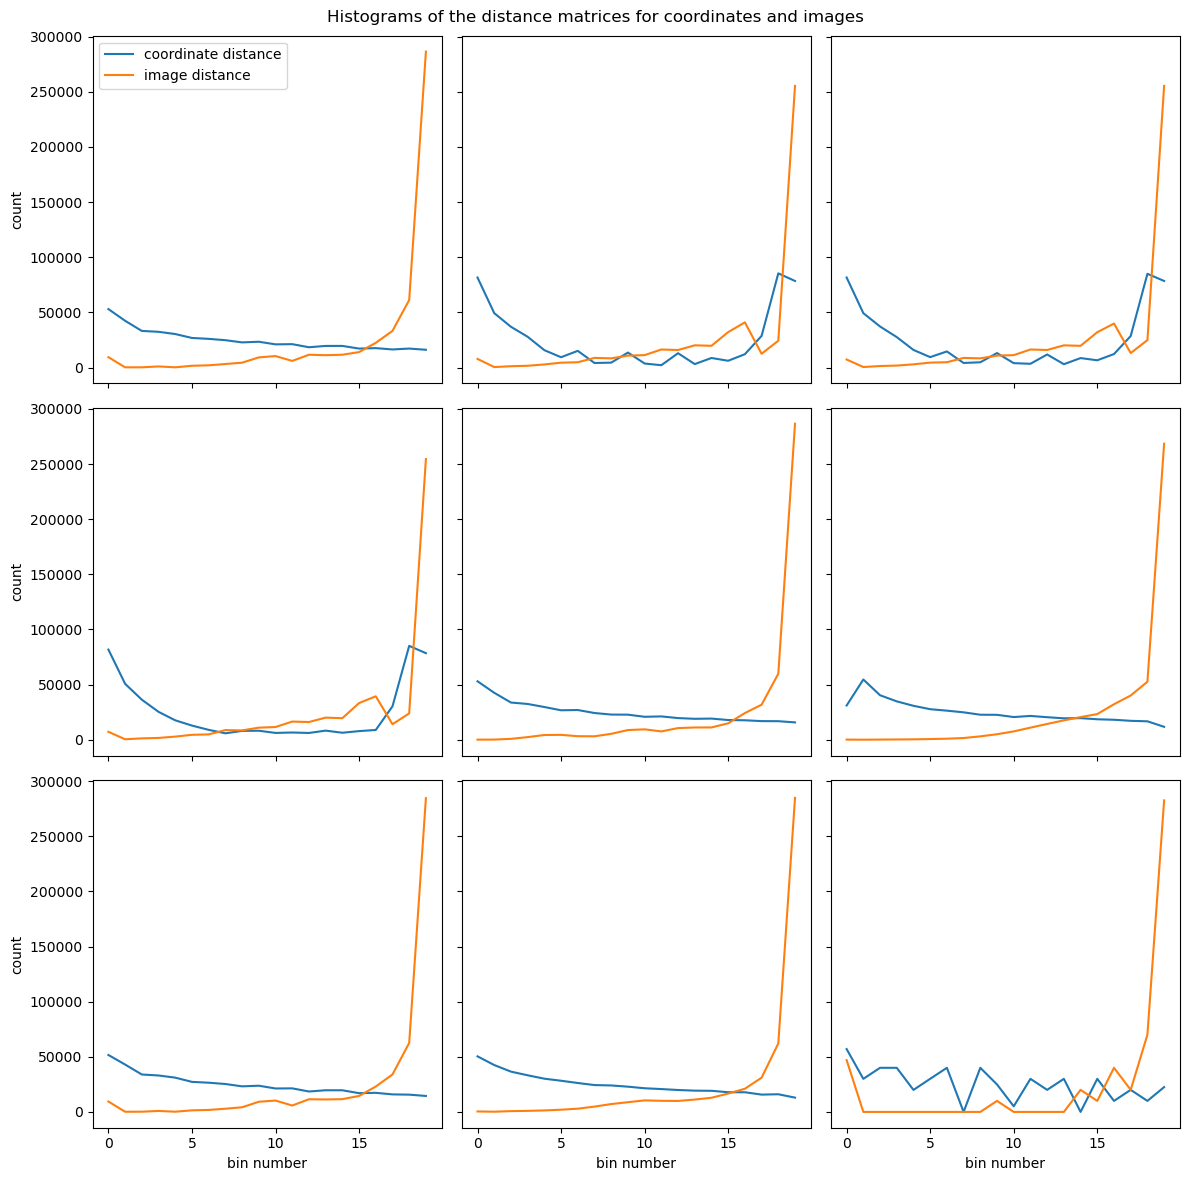

In [21]:
# for i in range(len(pc_taken)):
fig, ax_list, rows, cols = create_fig(samples_all, dpi=100,
                                      return_row_col=True,
                                      sharex=True,
                                      sharey=True)

for i in range(len(distances)):
    # mask = np.ones([len(pc_taken[i]), len(pc_taken[i])])
    # mask = (np.triu(mask, k=1)==1)
    # counts, bins = np.histogram(get_distance_matrix(pc_taken[i])[mask], bins=20)
    # ax_list[i].plot(range(20), counts, label='point distance in taken embedding')

    mask = np.ones(np.shape(distances[i]))
    mask = (np.triu(mask, k=1)==1)
    counts, bins = np.histogram(distances[i][mask], bins=20)
    ax_list[i].plot(range(20), counts, label='coordinate distance')

    mask = np.ones(np.shape(distances_images[i]))
    mask = (np.triu(mask, k=1)==1)
    counts, bins = np.histogram(distances_images[i][mask], bins=20)
    ax_list[i].plot(range(20), counts, label='image distance')

    # if the current axis is on the last row
    if i >= (rows - 1)*cols:
        ax_list[i].set_xlabel('bin number')
    # if the current axis is on the first column
    if i % cols == 0:
        ax_list[i].set_ylabel('count')
    ax_list[0].legend()

fig.suptitle('Histograms of the distance matrices for coordinates and images')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', f'histogram_{folders[i][:-4]}.png'))

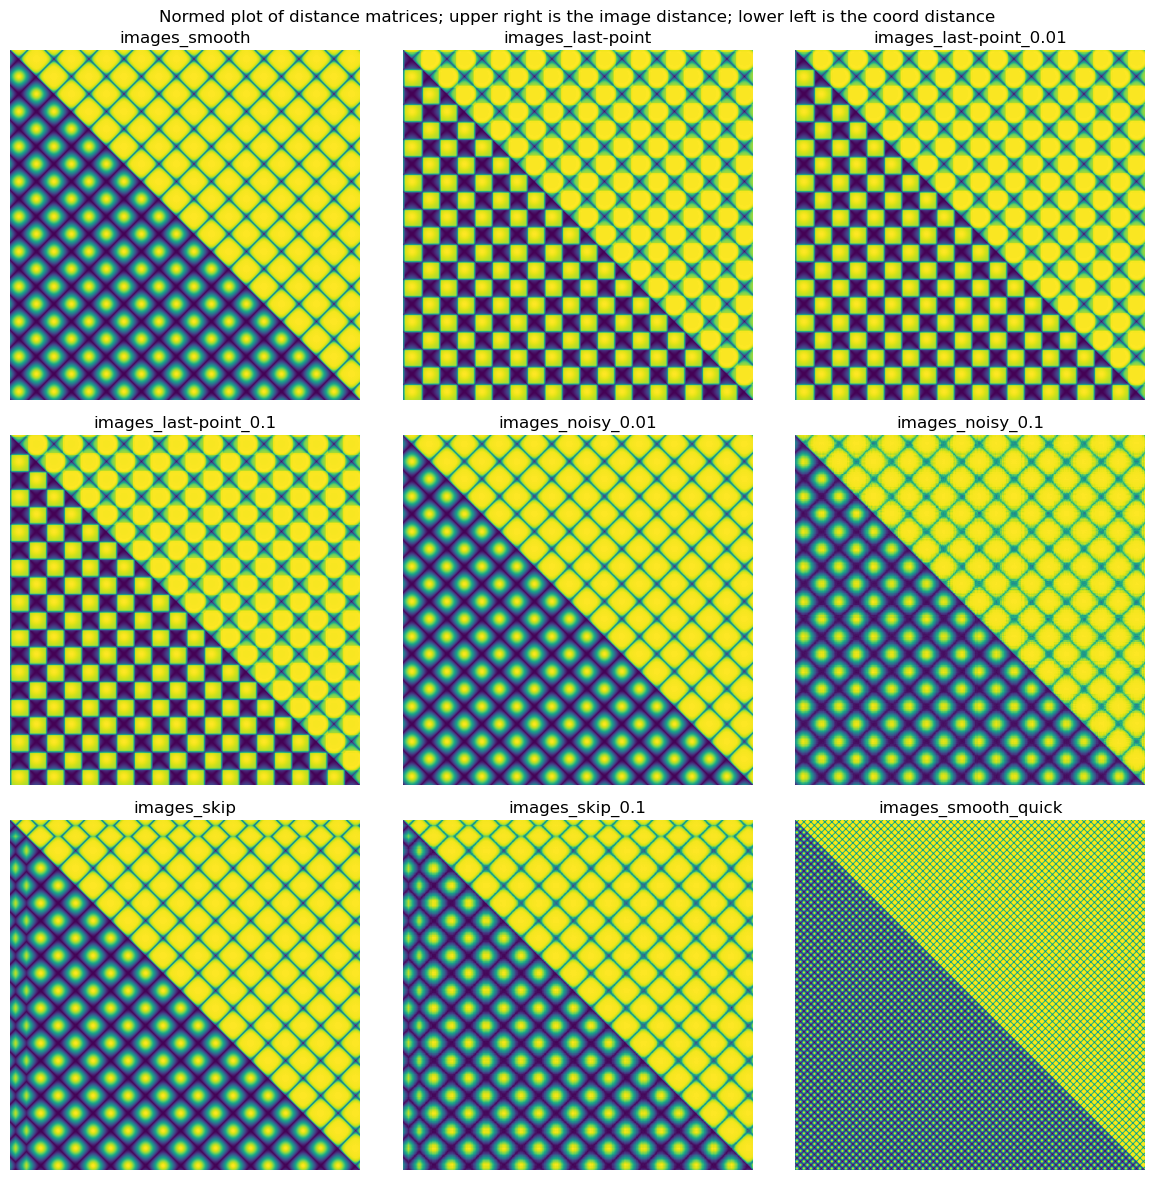

In [22]:
# distance matrices
for i in range(len(distances)):
    if np.shape(distances[i]) != np.shape(distances_images[i]):
        print(np.shape(distances[i]), np.shape(distances_images[i]))
        raise ValueError(f"distance and distance_images are not the same for {i}")

fig, ax_list = create_fig(distances, dpi=100,
                          sharex=True,
                          sharey=True)

for i in range(len(distances)):
    mask = np.ones(np.shape(distances[i]))
    mask = (np.triu(mask, k=1)==1)

    img = (distances[i] - np.min(distances[i][mask])) / (np.max(distances[i][mask]) - np.min(distances[i][mask]))

    tmp = (distances_images[i] - np.min(distances_images[i][mask])) / (np.max(distances_images[i][mask]) - np.min(distances_images[i][mask]))
    img[mask] = tmp[mask]

    ax_list[i].imshow(img)
    ax_list[i].set_title(folders[i])
    ax_list[i].axis('off')

fig.suptitle('Normed plot of distance matrices; upper right is the image distance; lower left is the coord distance')
fig.tight_layout()

fig.savefig(os.path.join(data_folder, 'plots', 'distance_matrices_coord-image-distance.png'))


## Persistence - Coordinate distance

PLot the different persistent diagrams

Get the distances between consective slices for each of the samples and their embedded point clouds

In [23]:
l2_coords = []
for _, _, points_plot in samples_all:
    l2_coords.append([np.linalg.norm(points_plot[i+1] - points_plot[i])
                      for i in range(points_plot.shape[0]-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2_coords)

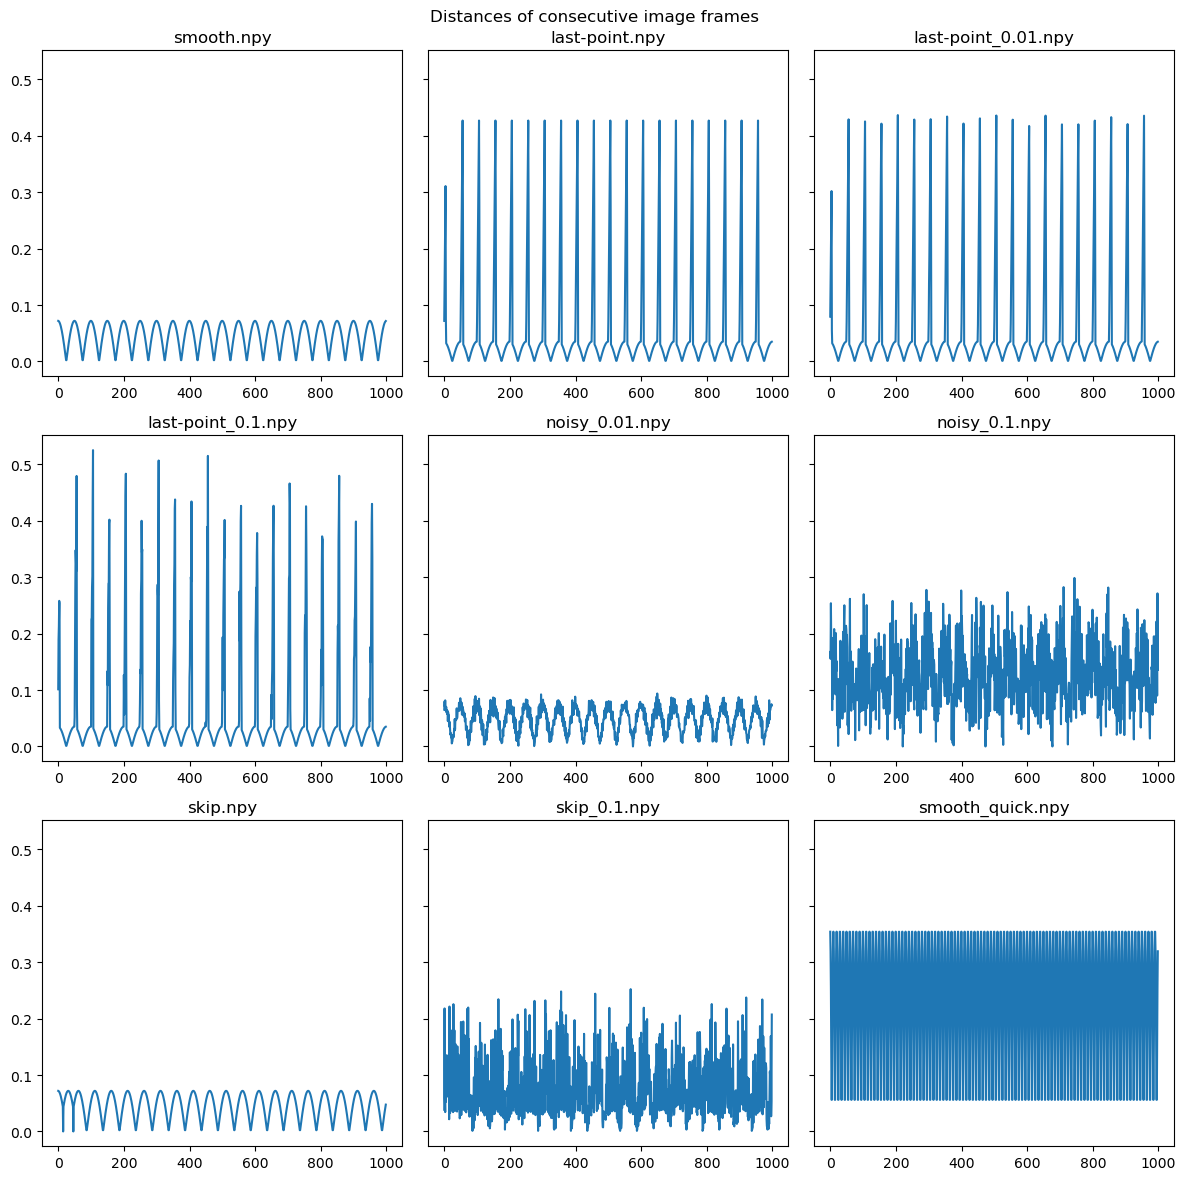

In [24]:
fig, ax_list = create_fig(samples_all, dpi=100, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].plot(range(len(l2_coords[i])), l2_coords[i])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Distances of consecutive image frames')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_distance_bw_consecutive_frames.png'))

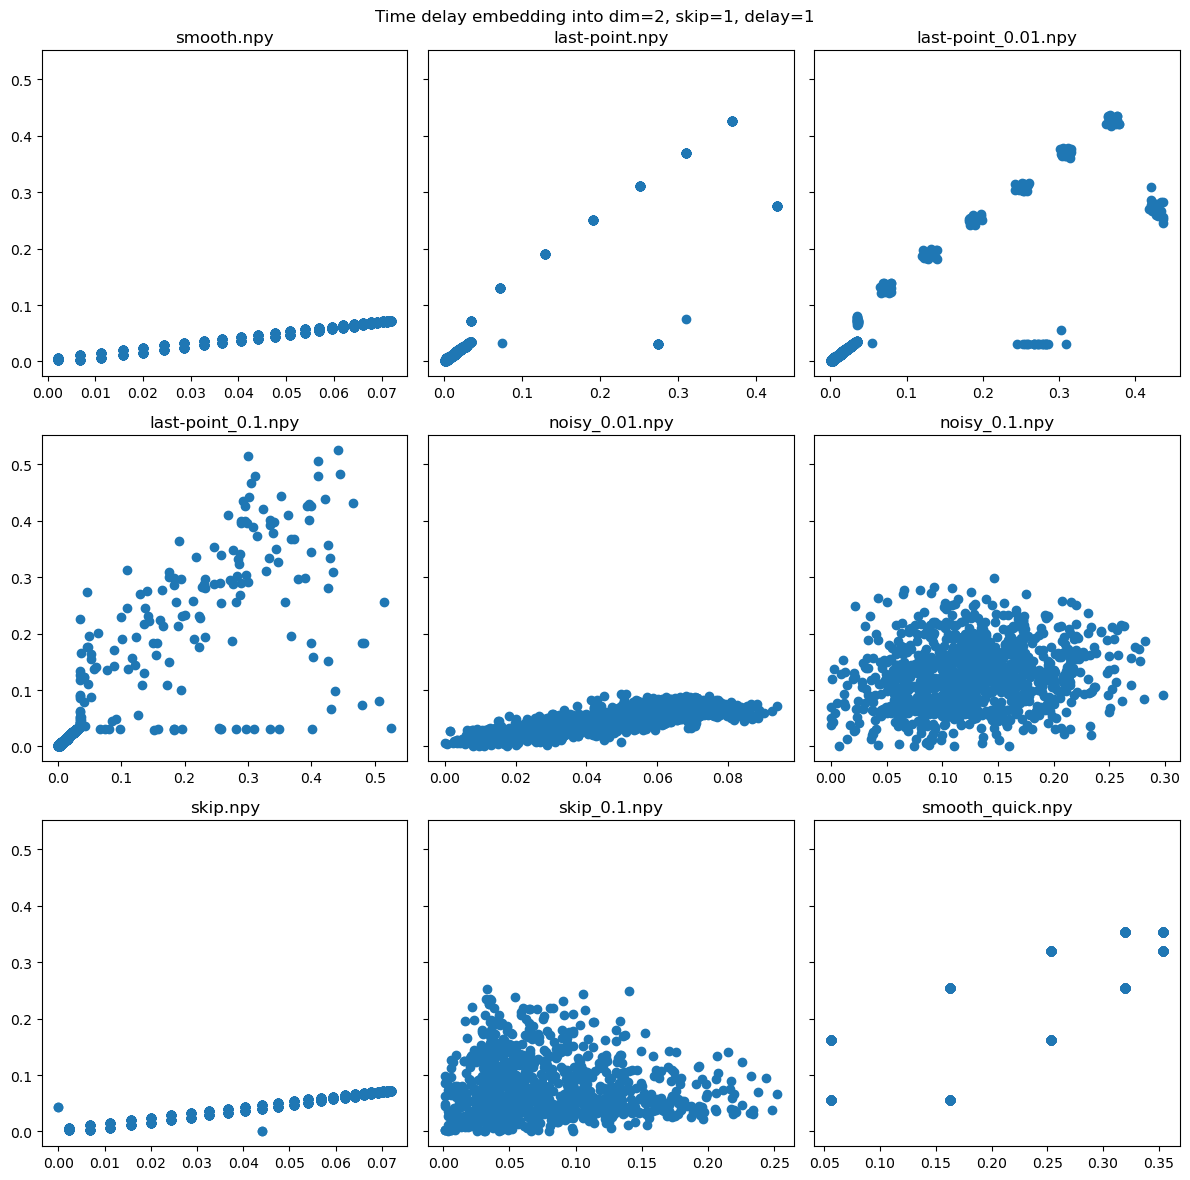

In [25]:
fig, ax_list = create_fig(samples_all, dpi=100, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].scatter(pc_taken[i][:, 0], pc_taken[i][:, 1])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Time delay embedding into dim=2, skip=1, delay=1')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_time_delay_consecutive_frames.png'))

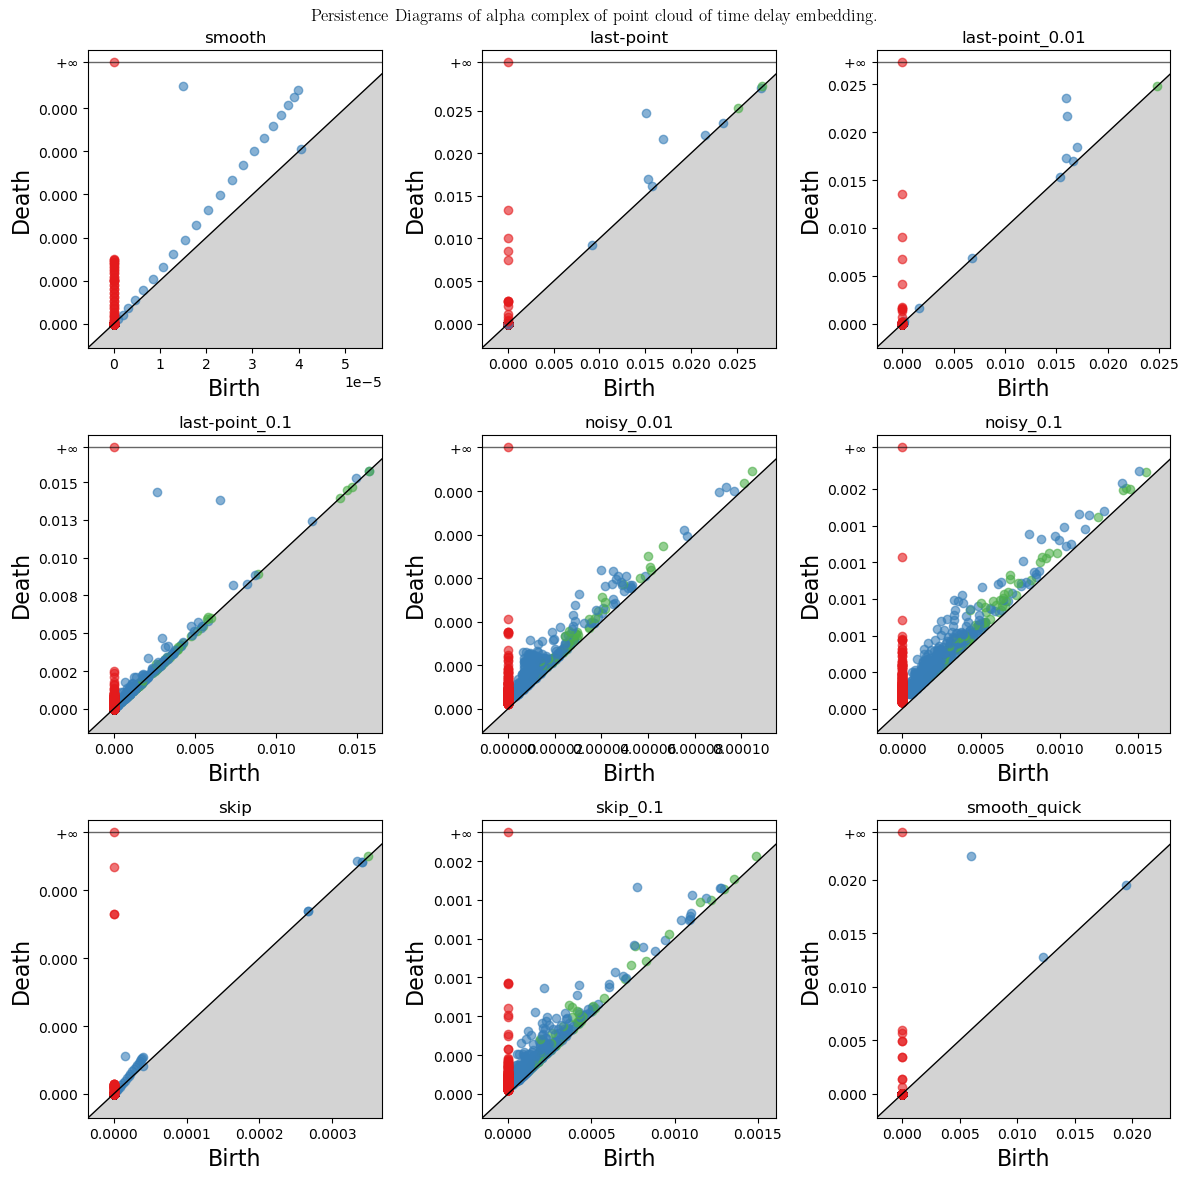

In [26]:
# fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)
fig, ax_list = create_fig(samples_all, dpi=100)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'coords_consecutive_alphacomplex.npz'))

# for i, txt, _ in samples_all:
#     print(folders[i], txt)
#     dgmX = diagram_convert(files[folders[i]])
#     gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
#     ax_list[i].set_title(txt)

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of alpha complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_alpha_timedelay.png'))

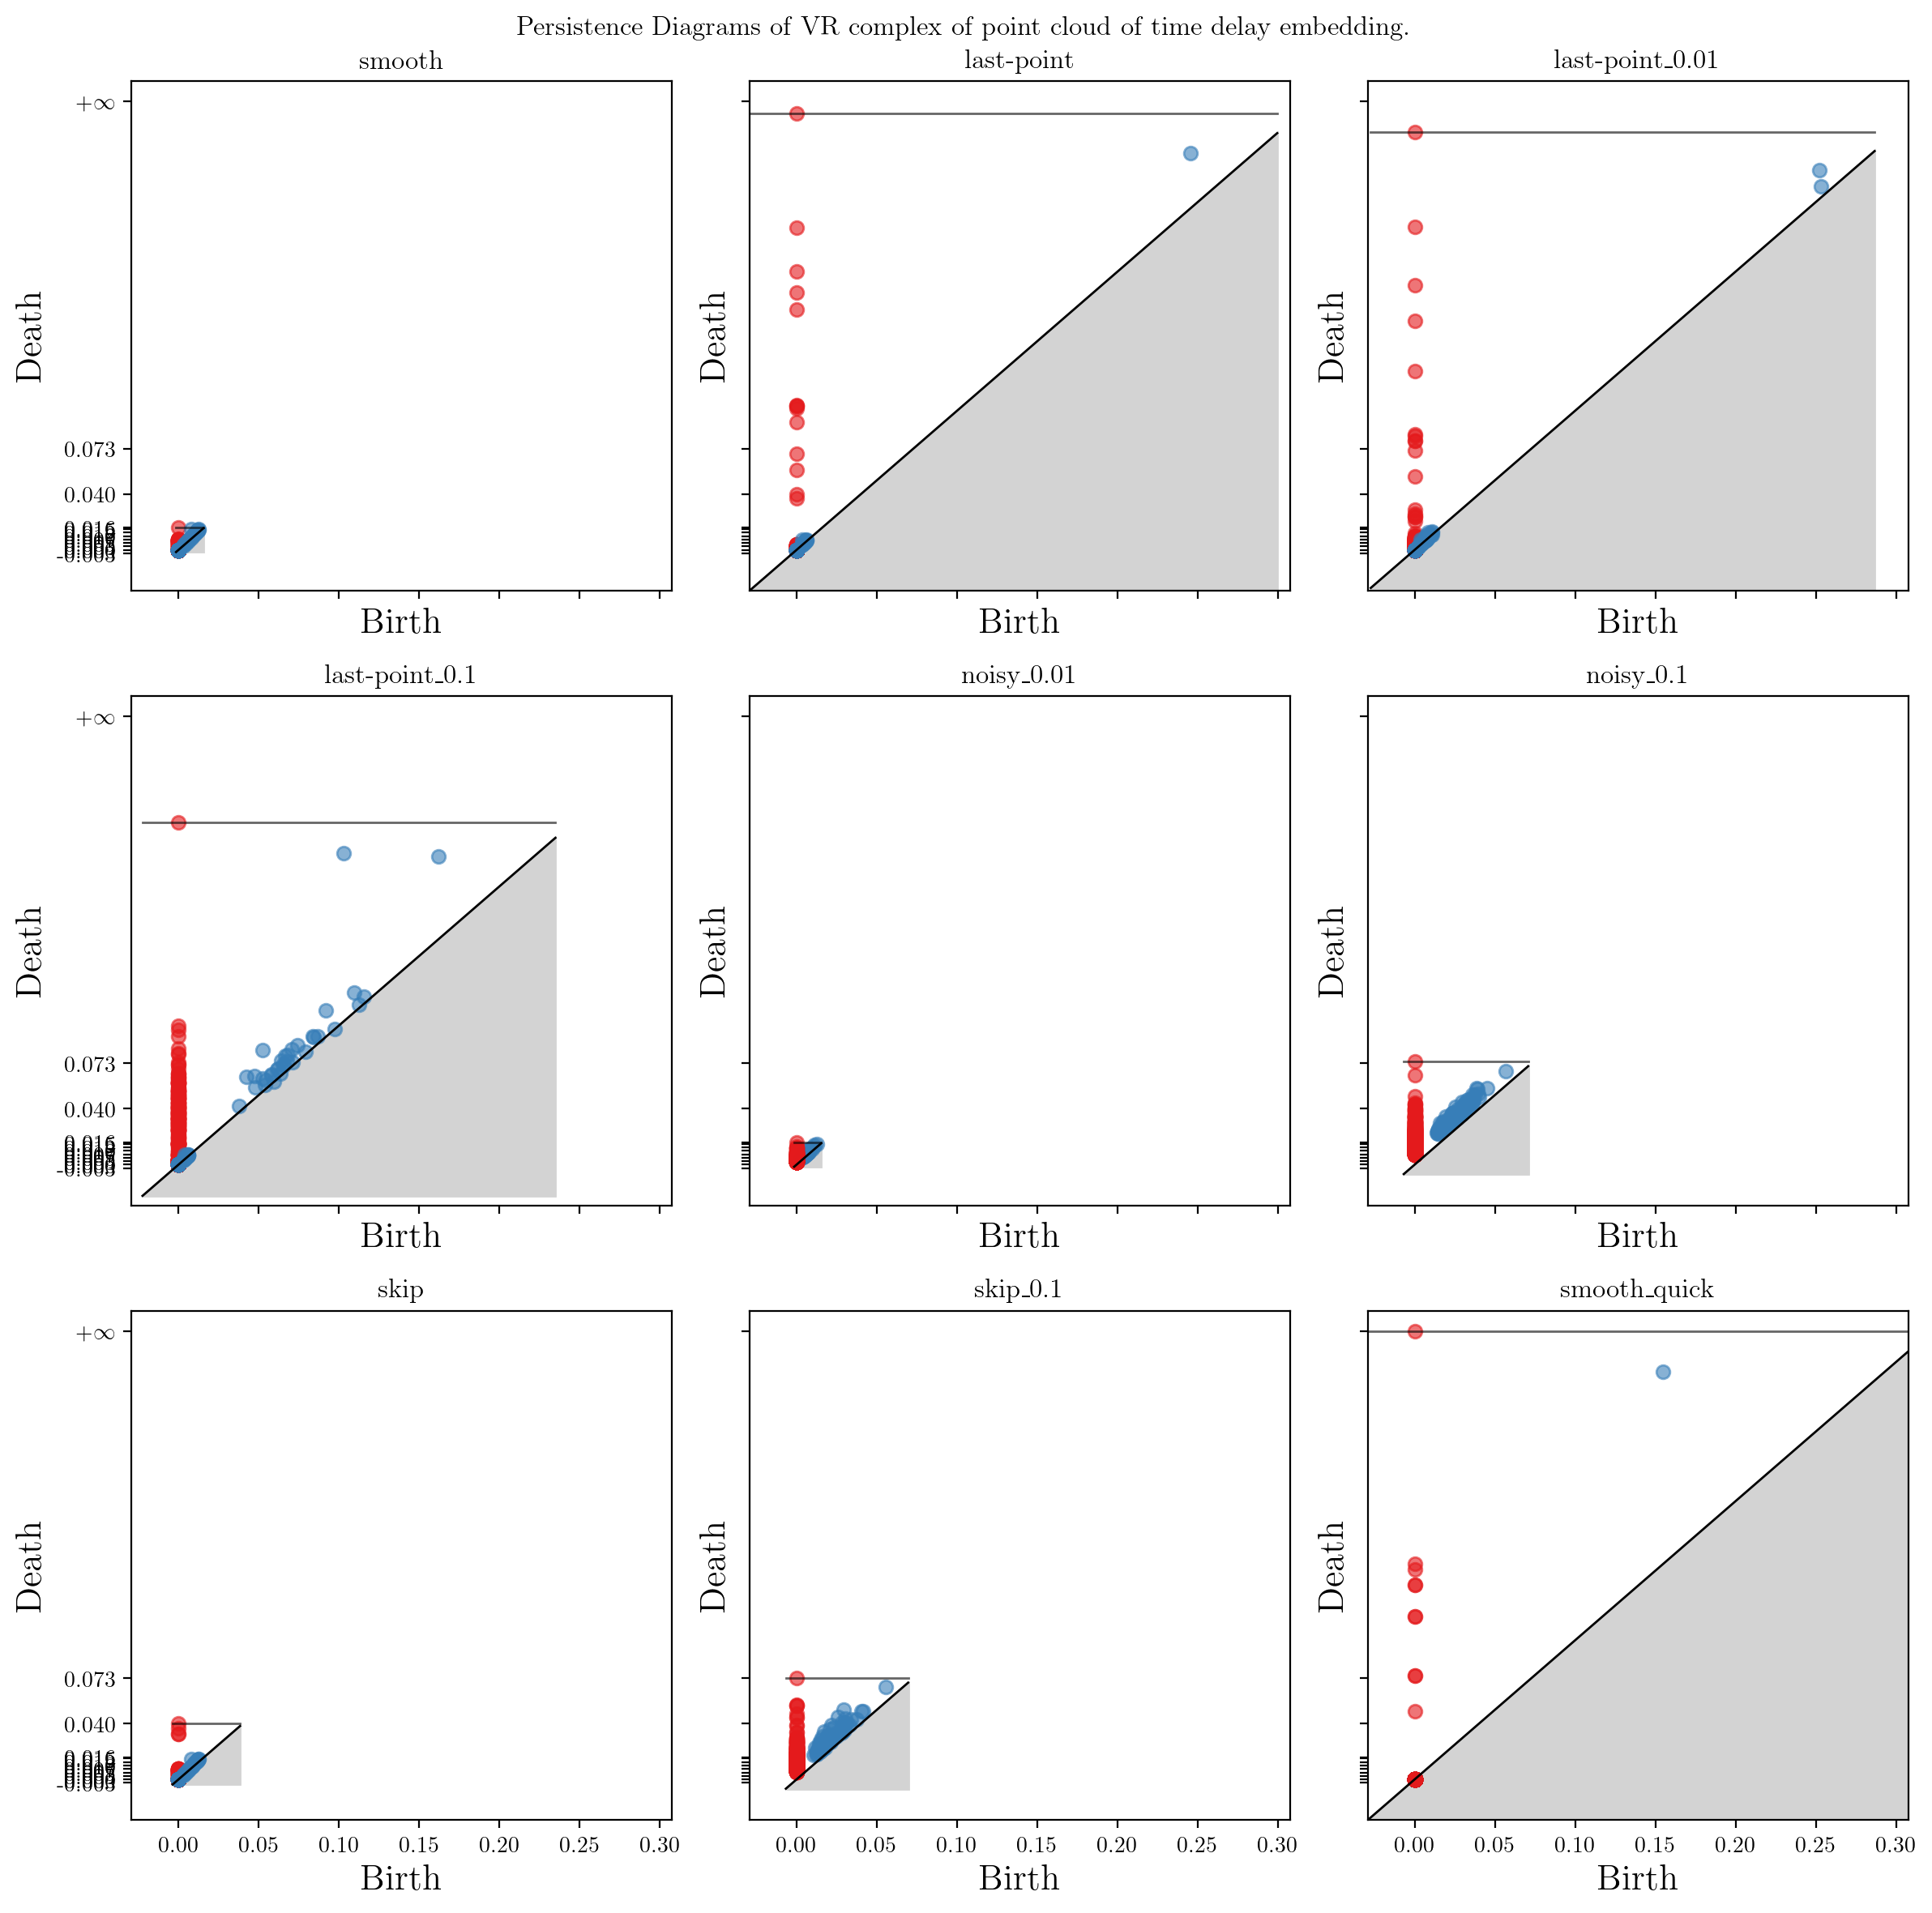

In [27]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'coords_consecutive_VRcomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))
    
for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of VR complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_VR_timedelay.png'))

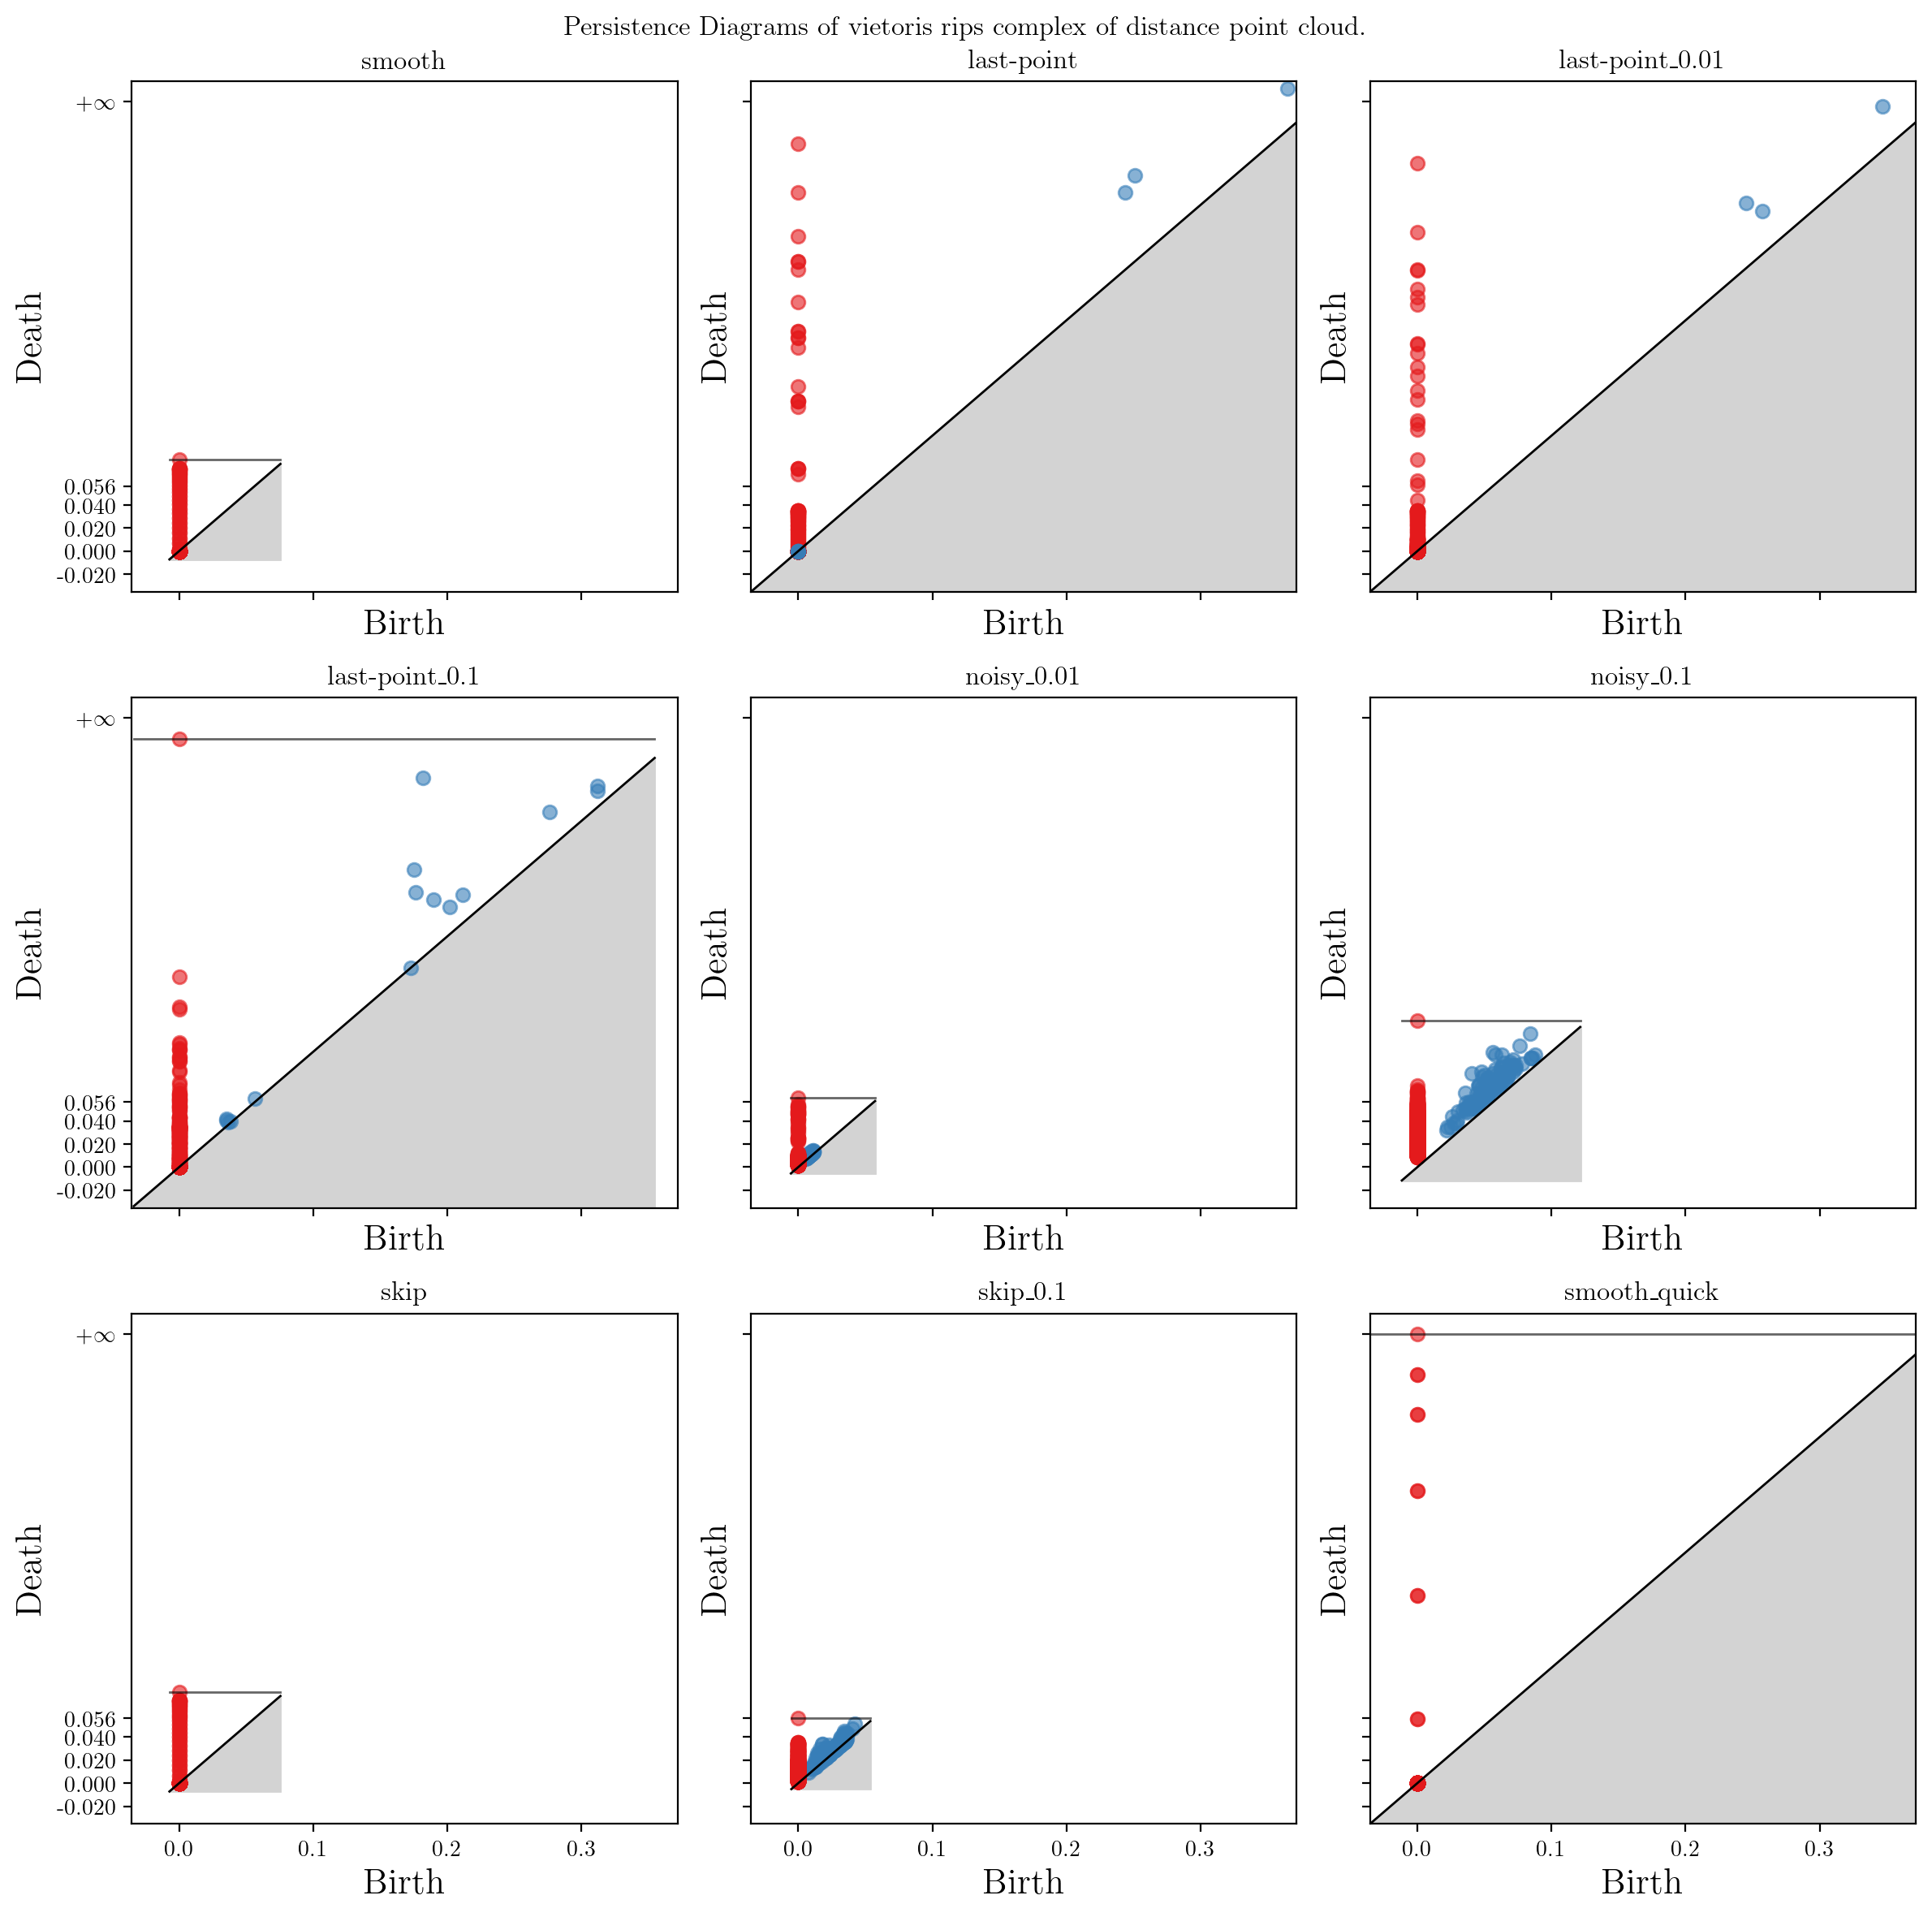

In [28]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'coords_distmatrix_VRcomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of vietoris rips complex'
             + ' of distance point cloud.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'coords_VR_pwDistances.png'))

## Persistence - Image distance

Get the pairwise distances of the images as matrices:

In [29]:
if os.path.isfile(os.path.join(data_folder, 'distances/distances_images.npz')):
    distances_images = np.load(os.path.join(data_folder, 'distances/distances_images.npz'))
    names = distances_images['names']
    distances_images = distances_images['distances']
else:
    distances_images = []
    for folder in folders:
        files = os.listdir(os.path.join(data_folder, f'images/{folder}'))
        files.sort()

        print(folder)
        print(' - Read in images')
        images = []
        for file in tqdm(files):
            img = skio.imread(os.path.join(data_folder, f'images/{folder}/{file}'))[:, :, :3]
            img = np.uint8(rgb2gray(img))
            images.append(np.array(img < 1, dtype=np.int32))

        print(' - Create distance matrix')
        dist_mat = np.zeros([len(images), len(images)])
        for i in tqdm(range(len(images))):
            for j in range(i+1, len(images)):
                dist_mat[i, j] = np.linalg.norm(images[i] - images[j])
                dist_mat[j, i] = dist_mat[i, j]
            
        distances_images.append(dist_mat)

    distances_images = np.array(distances_images)
    np.savez_compressed(os.path.join(data_folder, 'distances', 'distances_images.npz'),
                        names=[folder for folder in folders],
                        distances=distances_images)

In [30]:
l2 = []
for k, folder in enumerate(folders):
    l2.append([np.linalg.norm(distances_images[k][i+1, i])
               for i in range(len(distances_images[k])-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2)

### Now plot the persistence diagrams (and calculate the persistence):

Distances between consecutive x,y positions for different times.

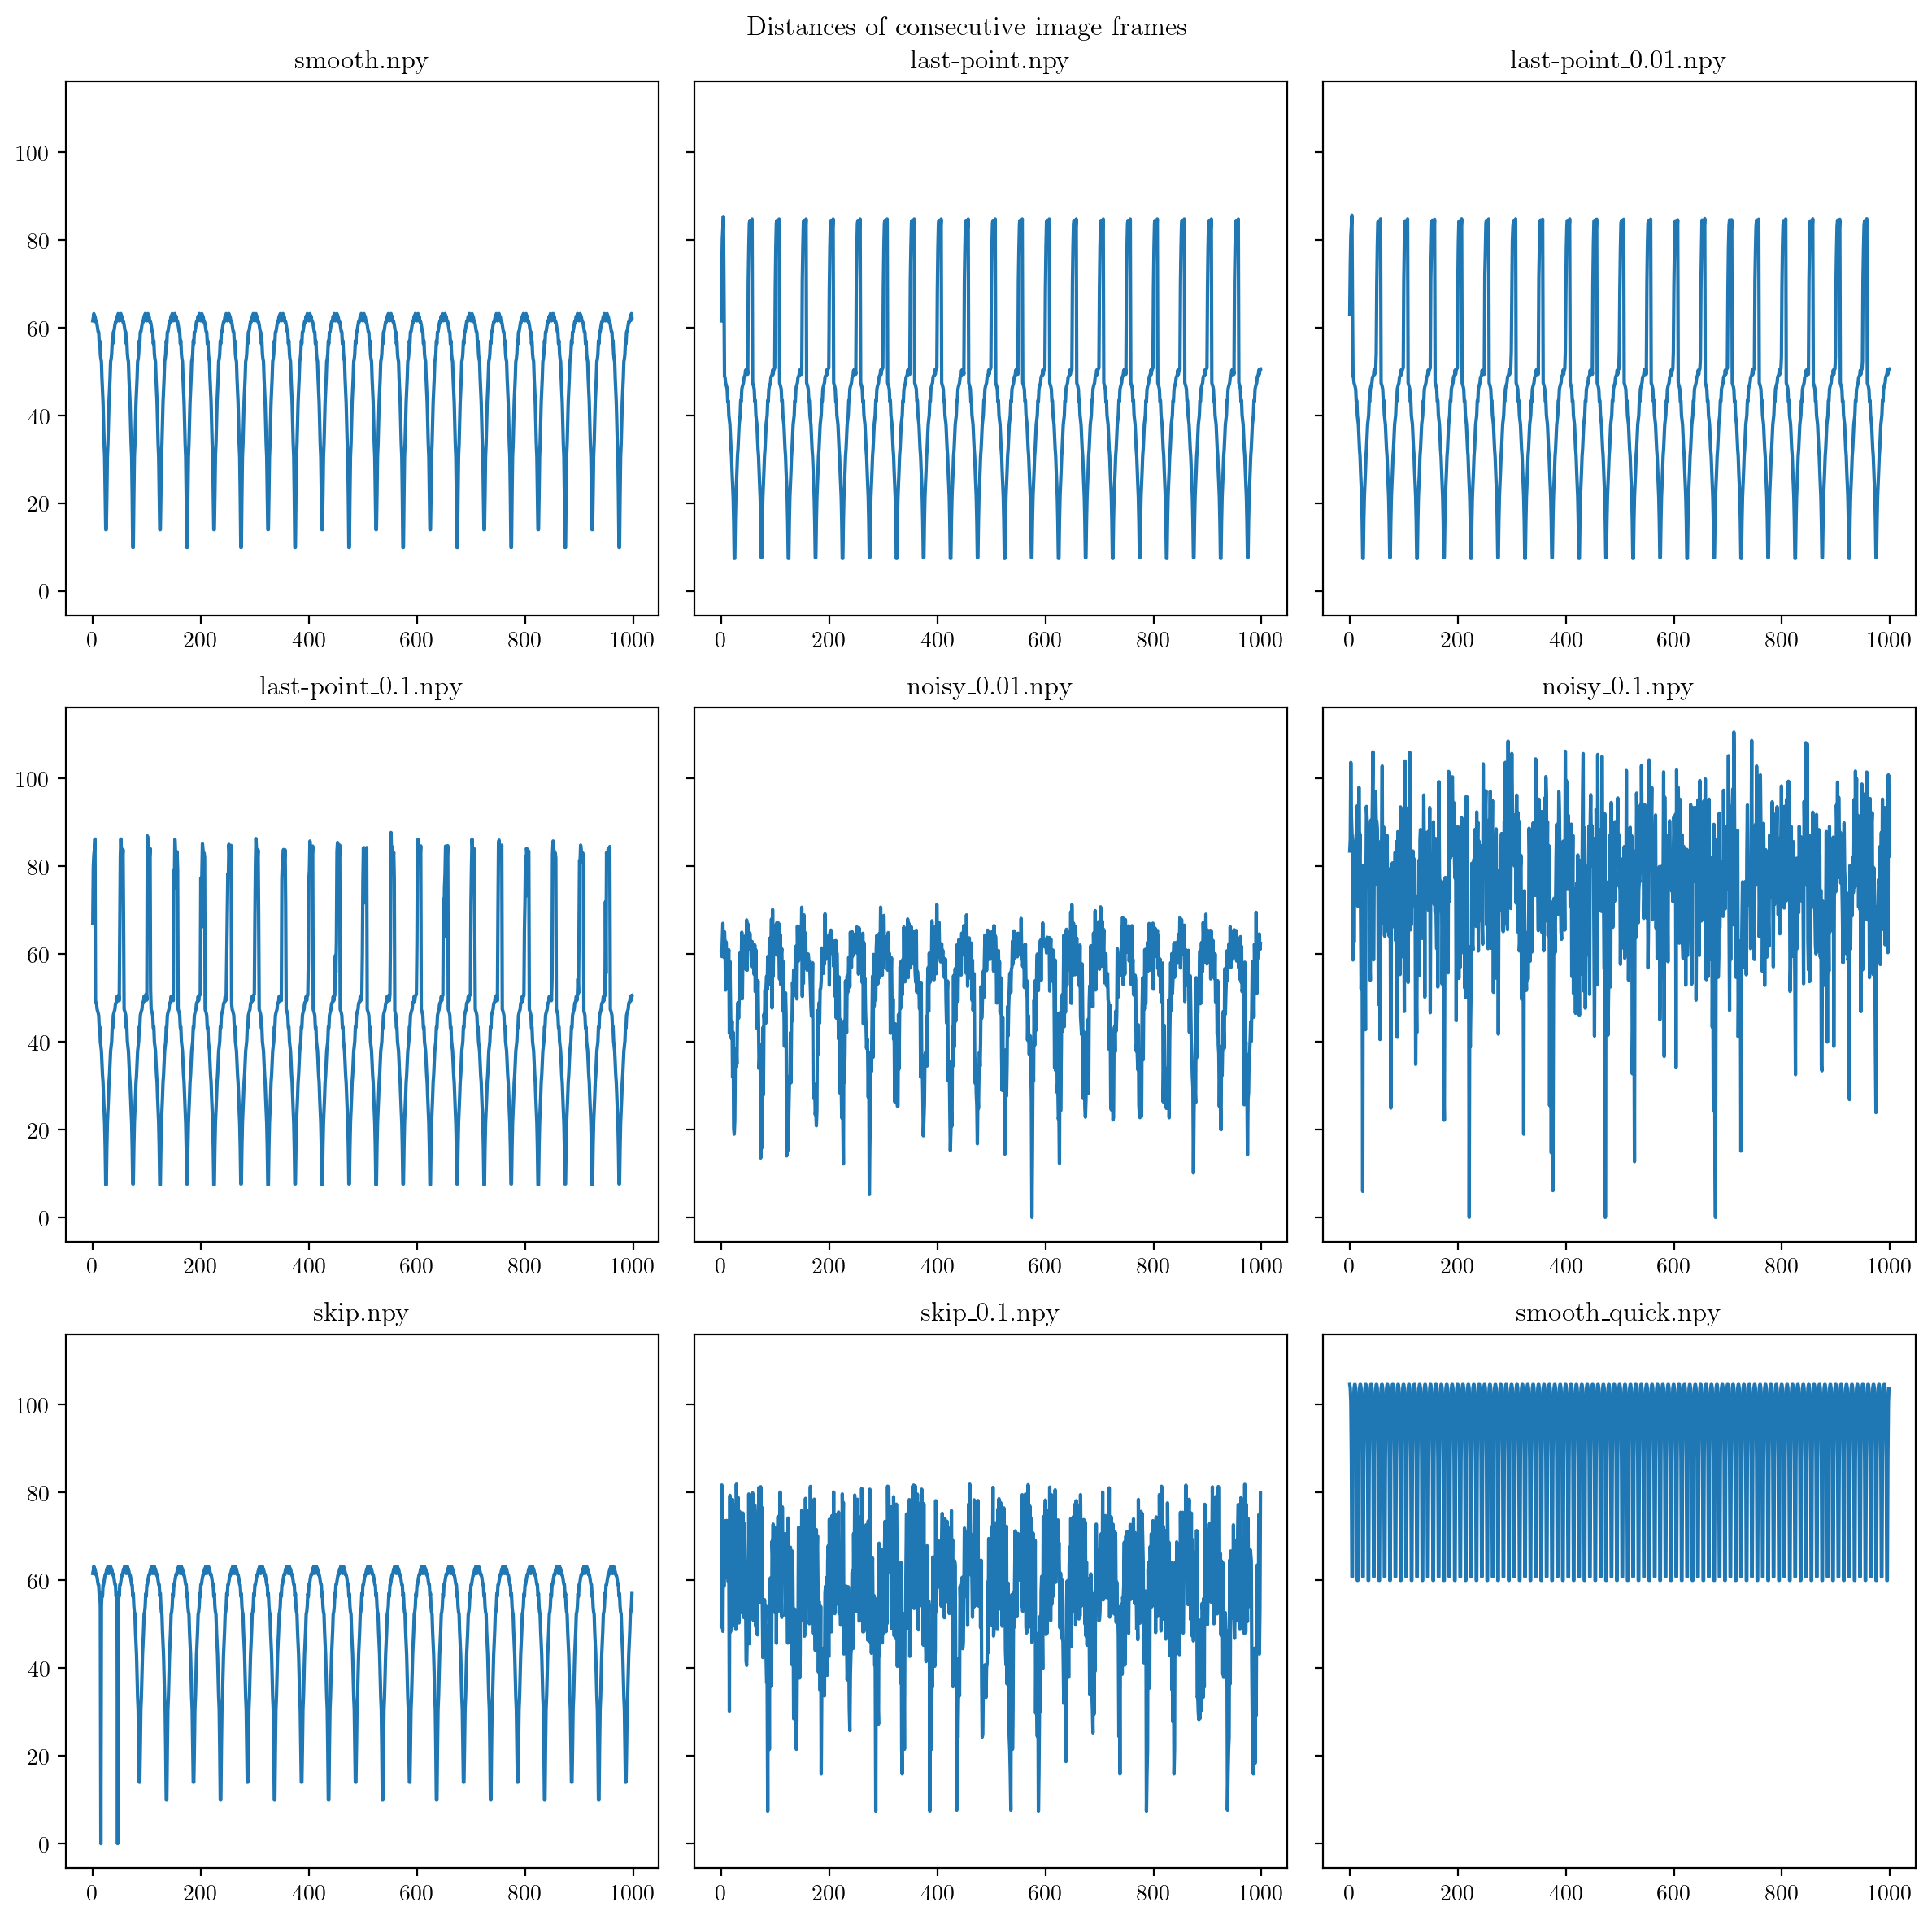

In [31]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].plot(range(len(l2[i])), l2[i])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Distances of consecutive image frames')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_distance_bw_consecutive_frames.png'))

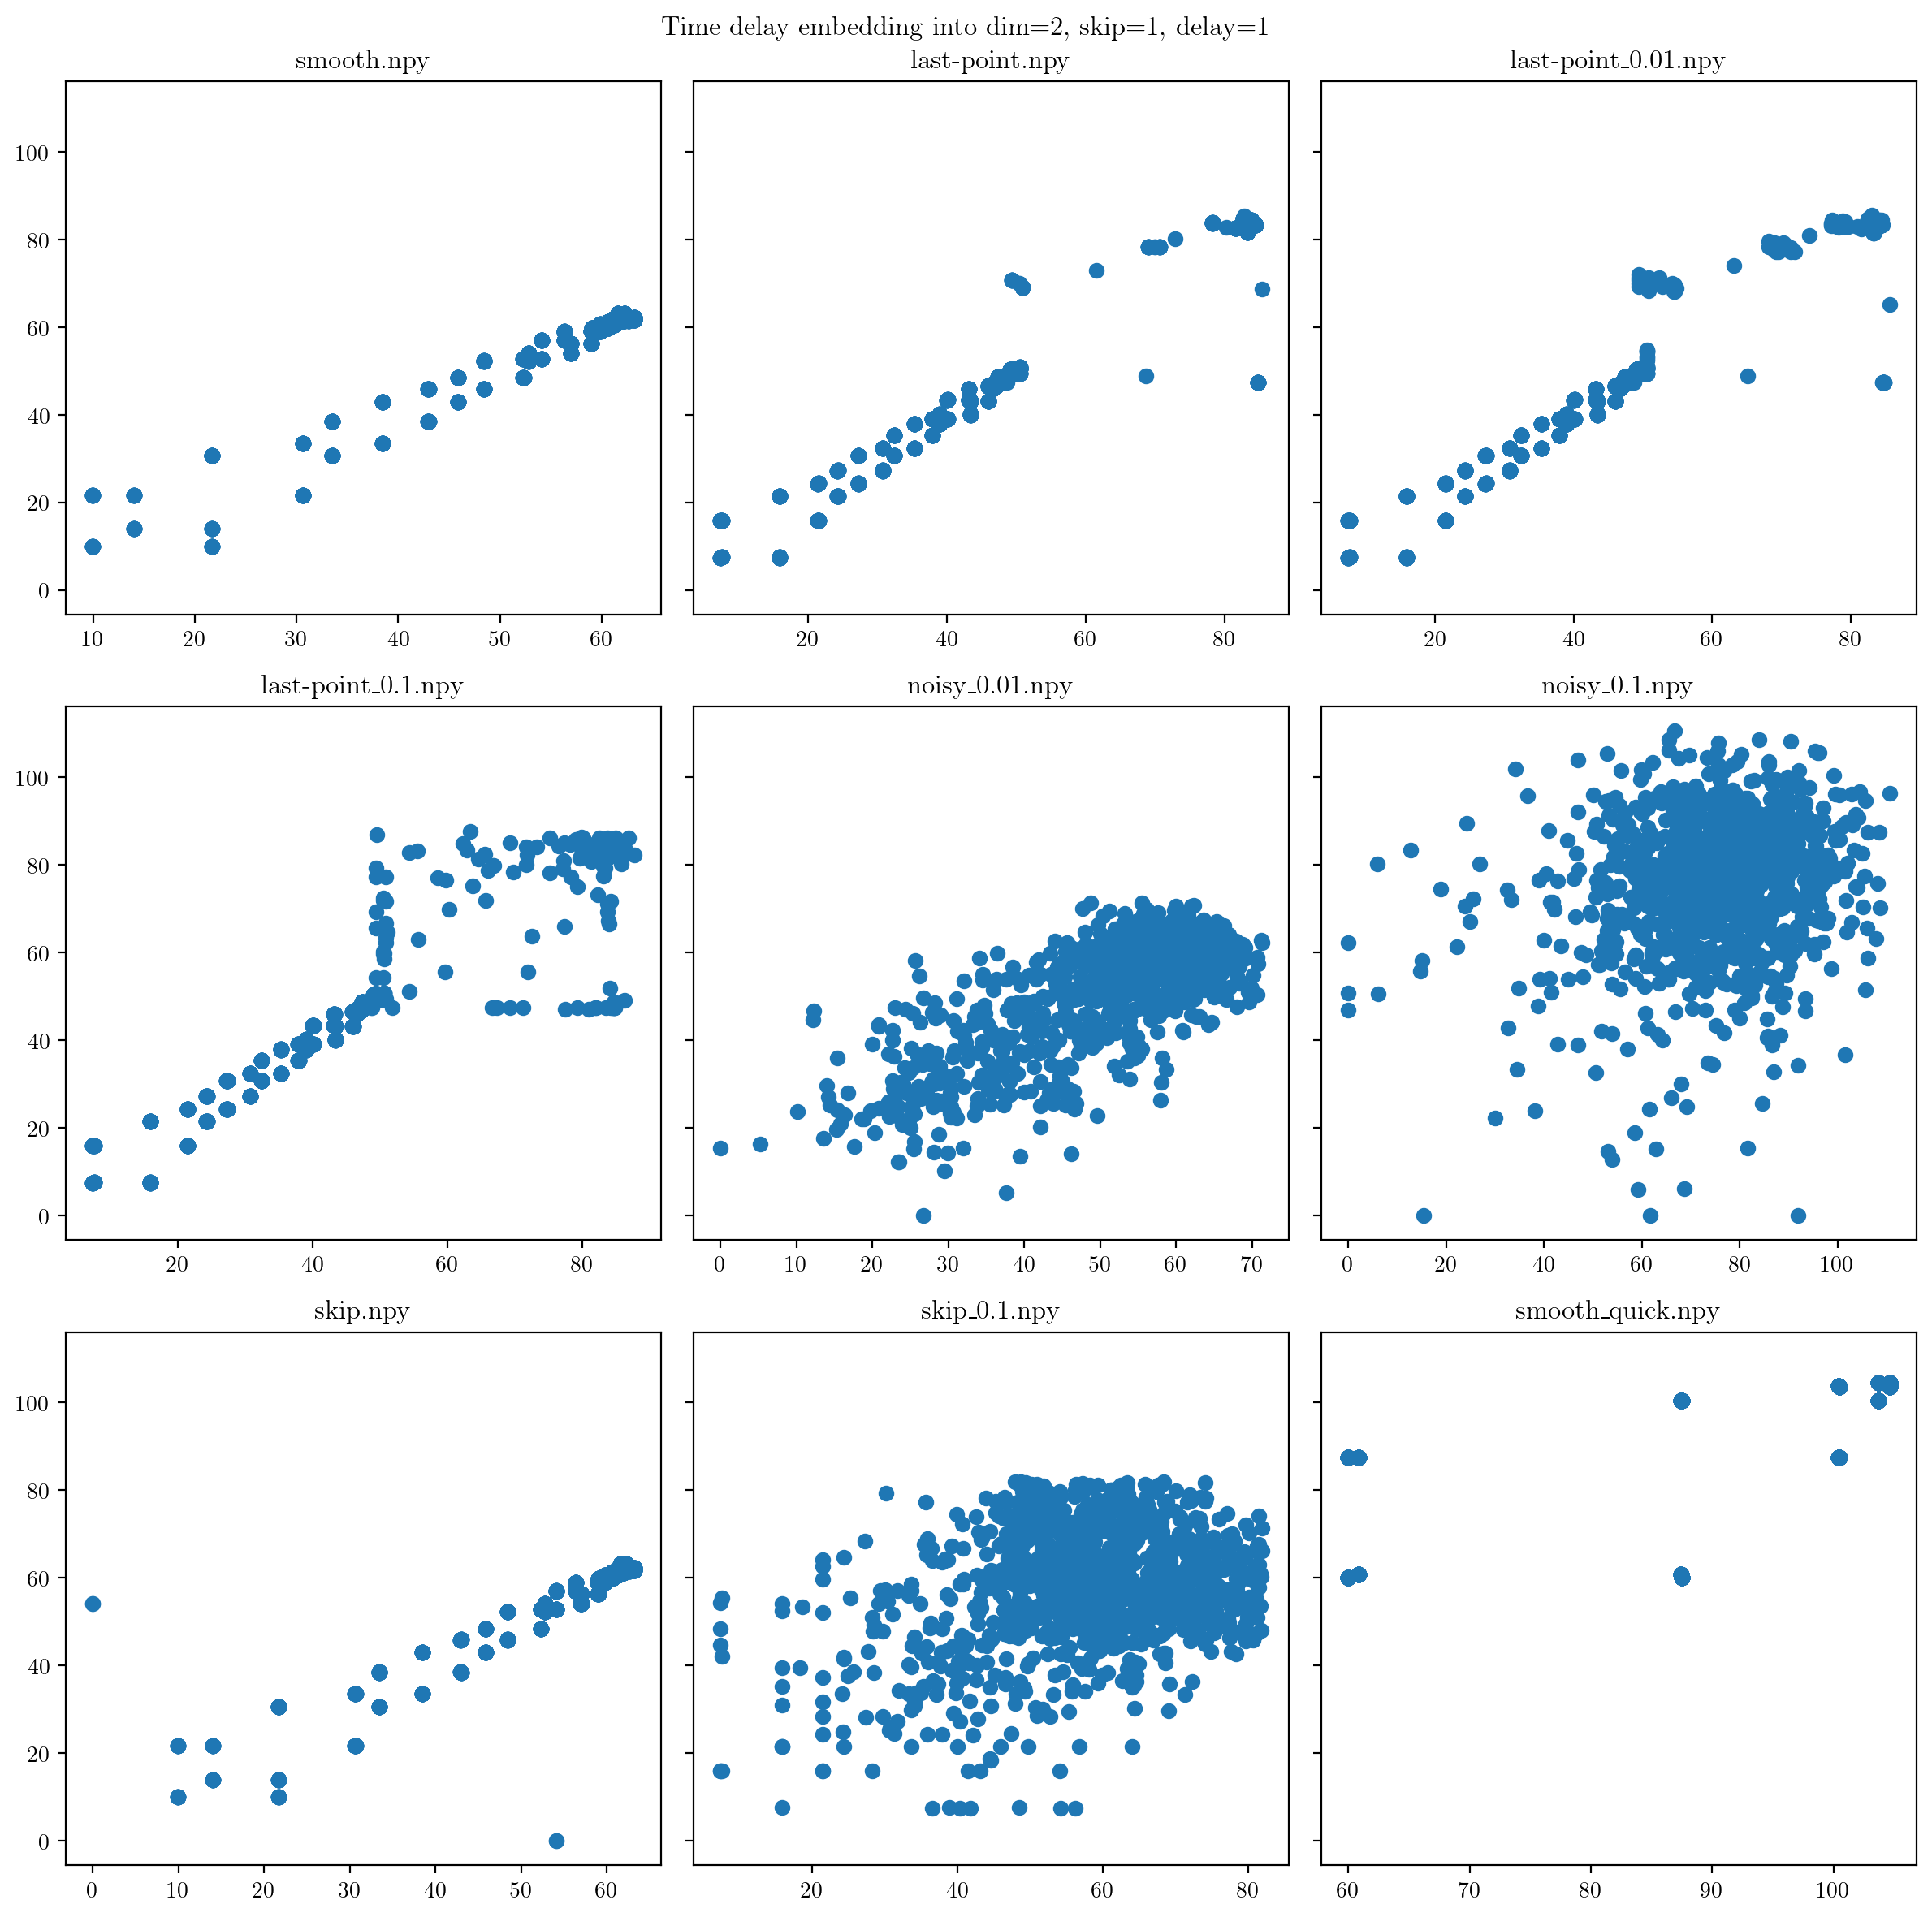

In [32]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True)

for i in range(len(samples_all)):
    ax_list[i].scatter(pc_taken[i][:, 0], pc_taken[i][:, 1])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Time delay embedding into dim=2, skip=1, delay=1')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_time_delay_consecutive_frames.png'))

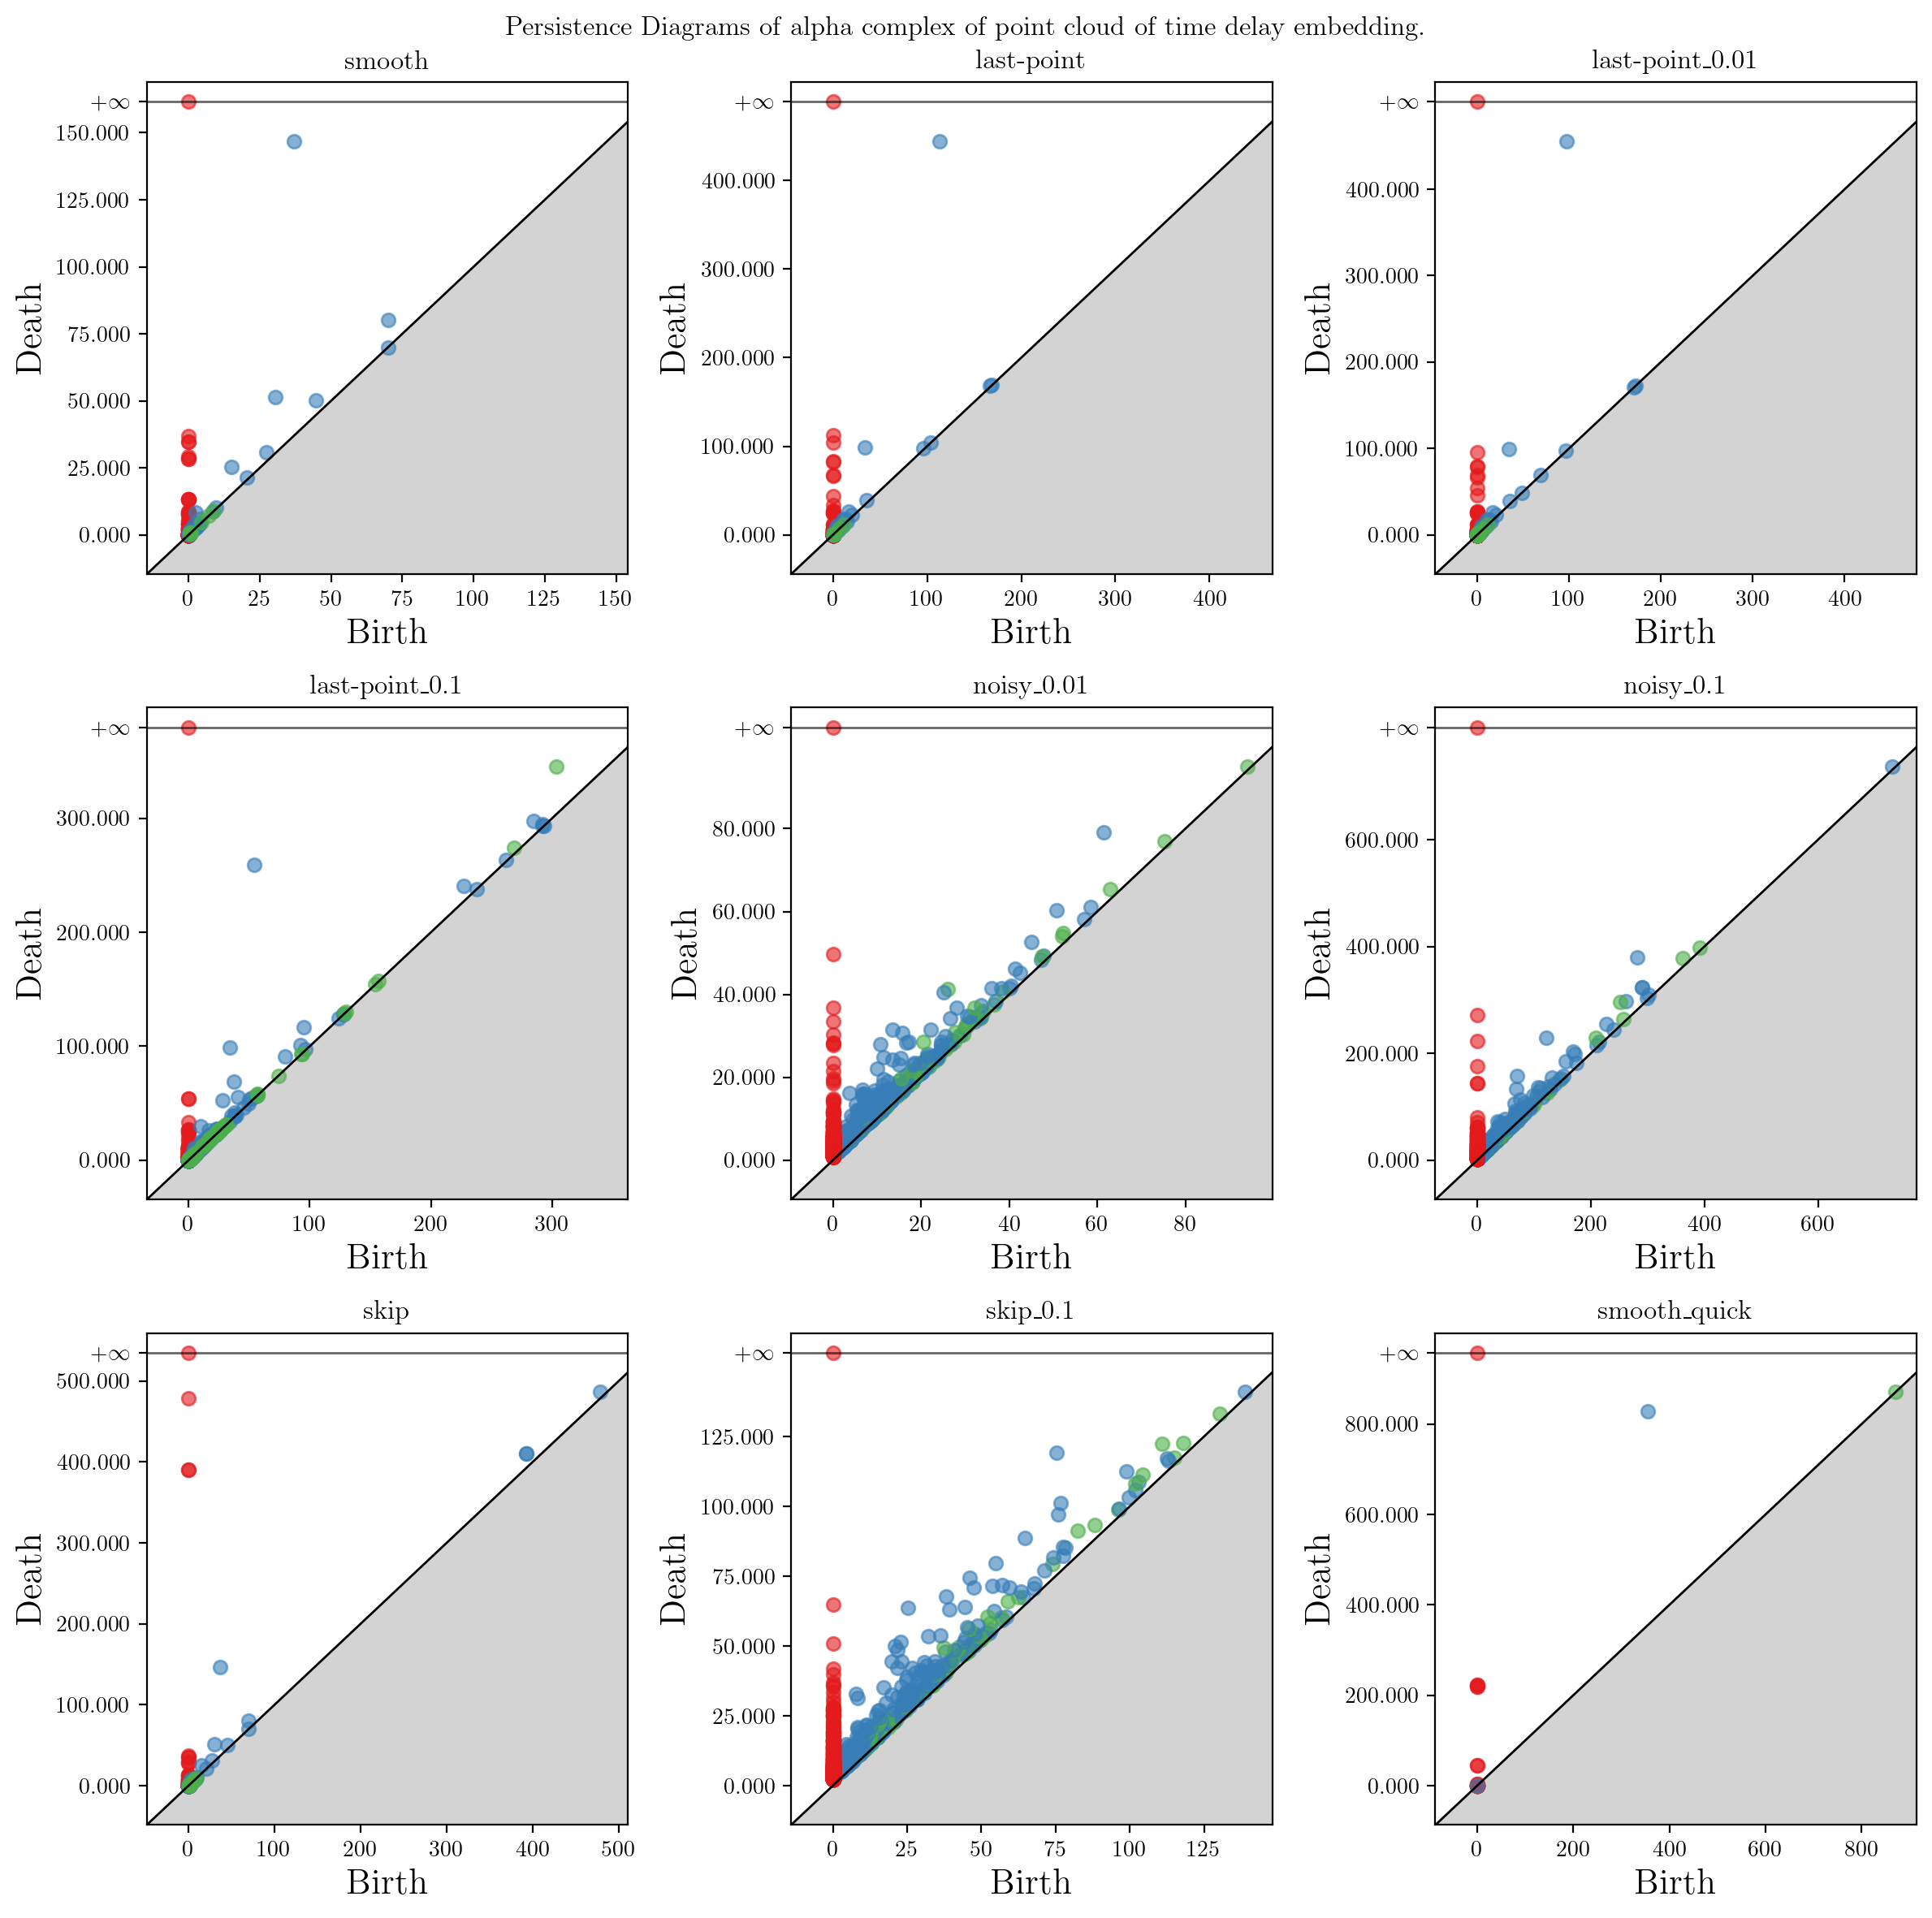

In [33]:
# fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)
fig, ax_list = create_fig(samples_all, dpi=200)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'images_consecutive_alphacomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of alpha complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_alpha_timedelay.png'))

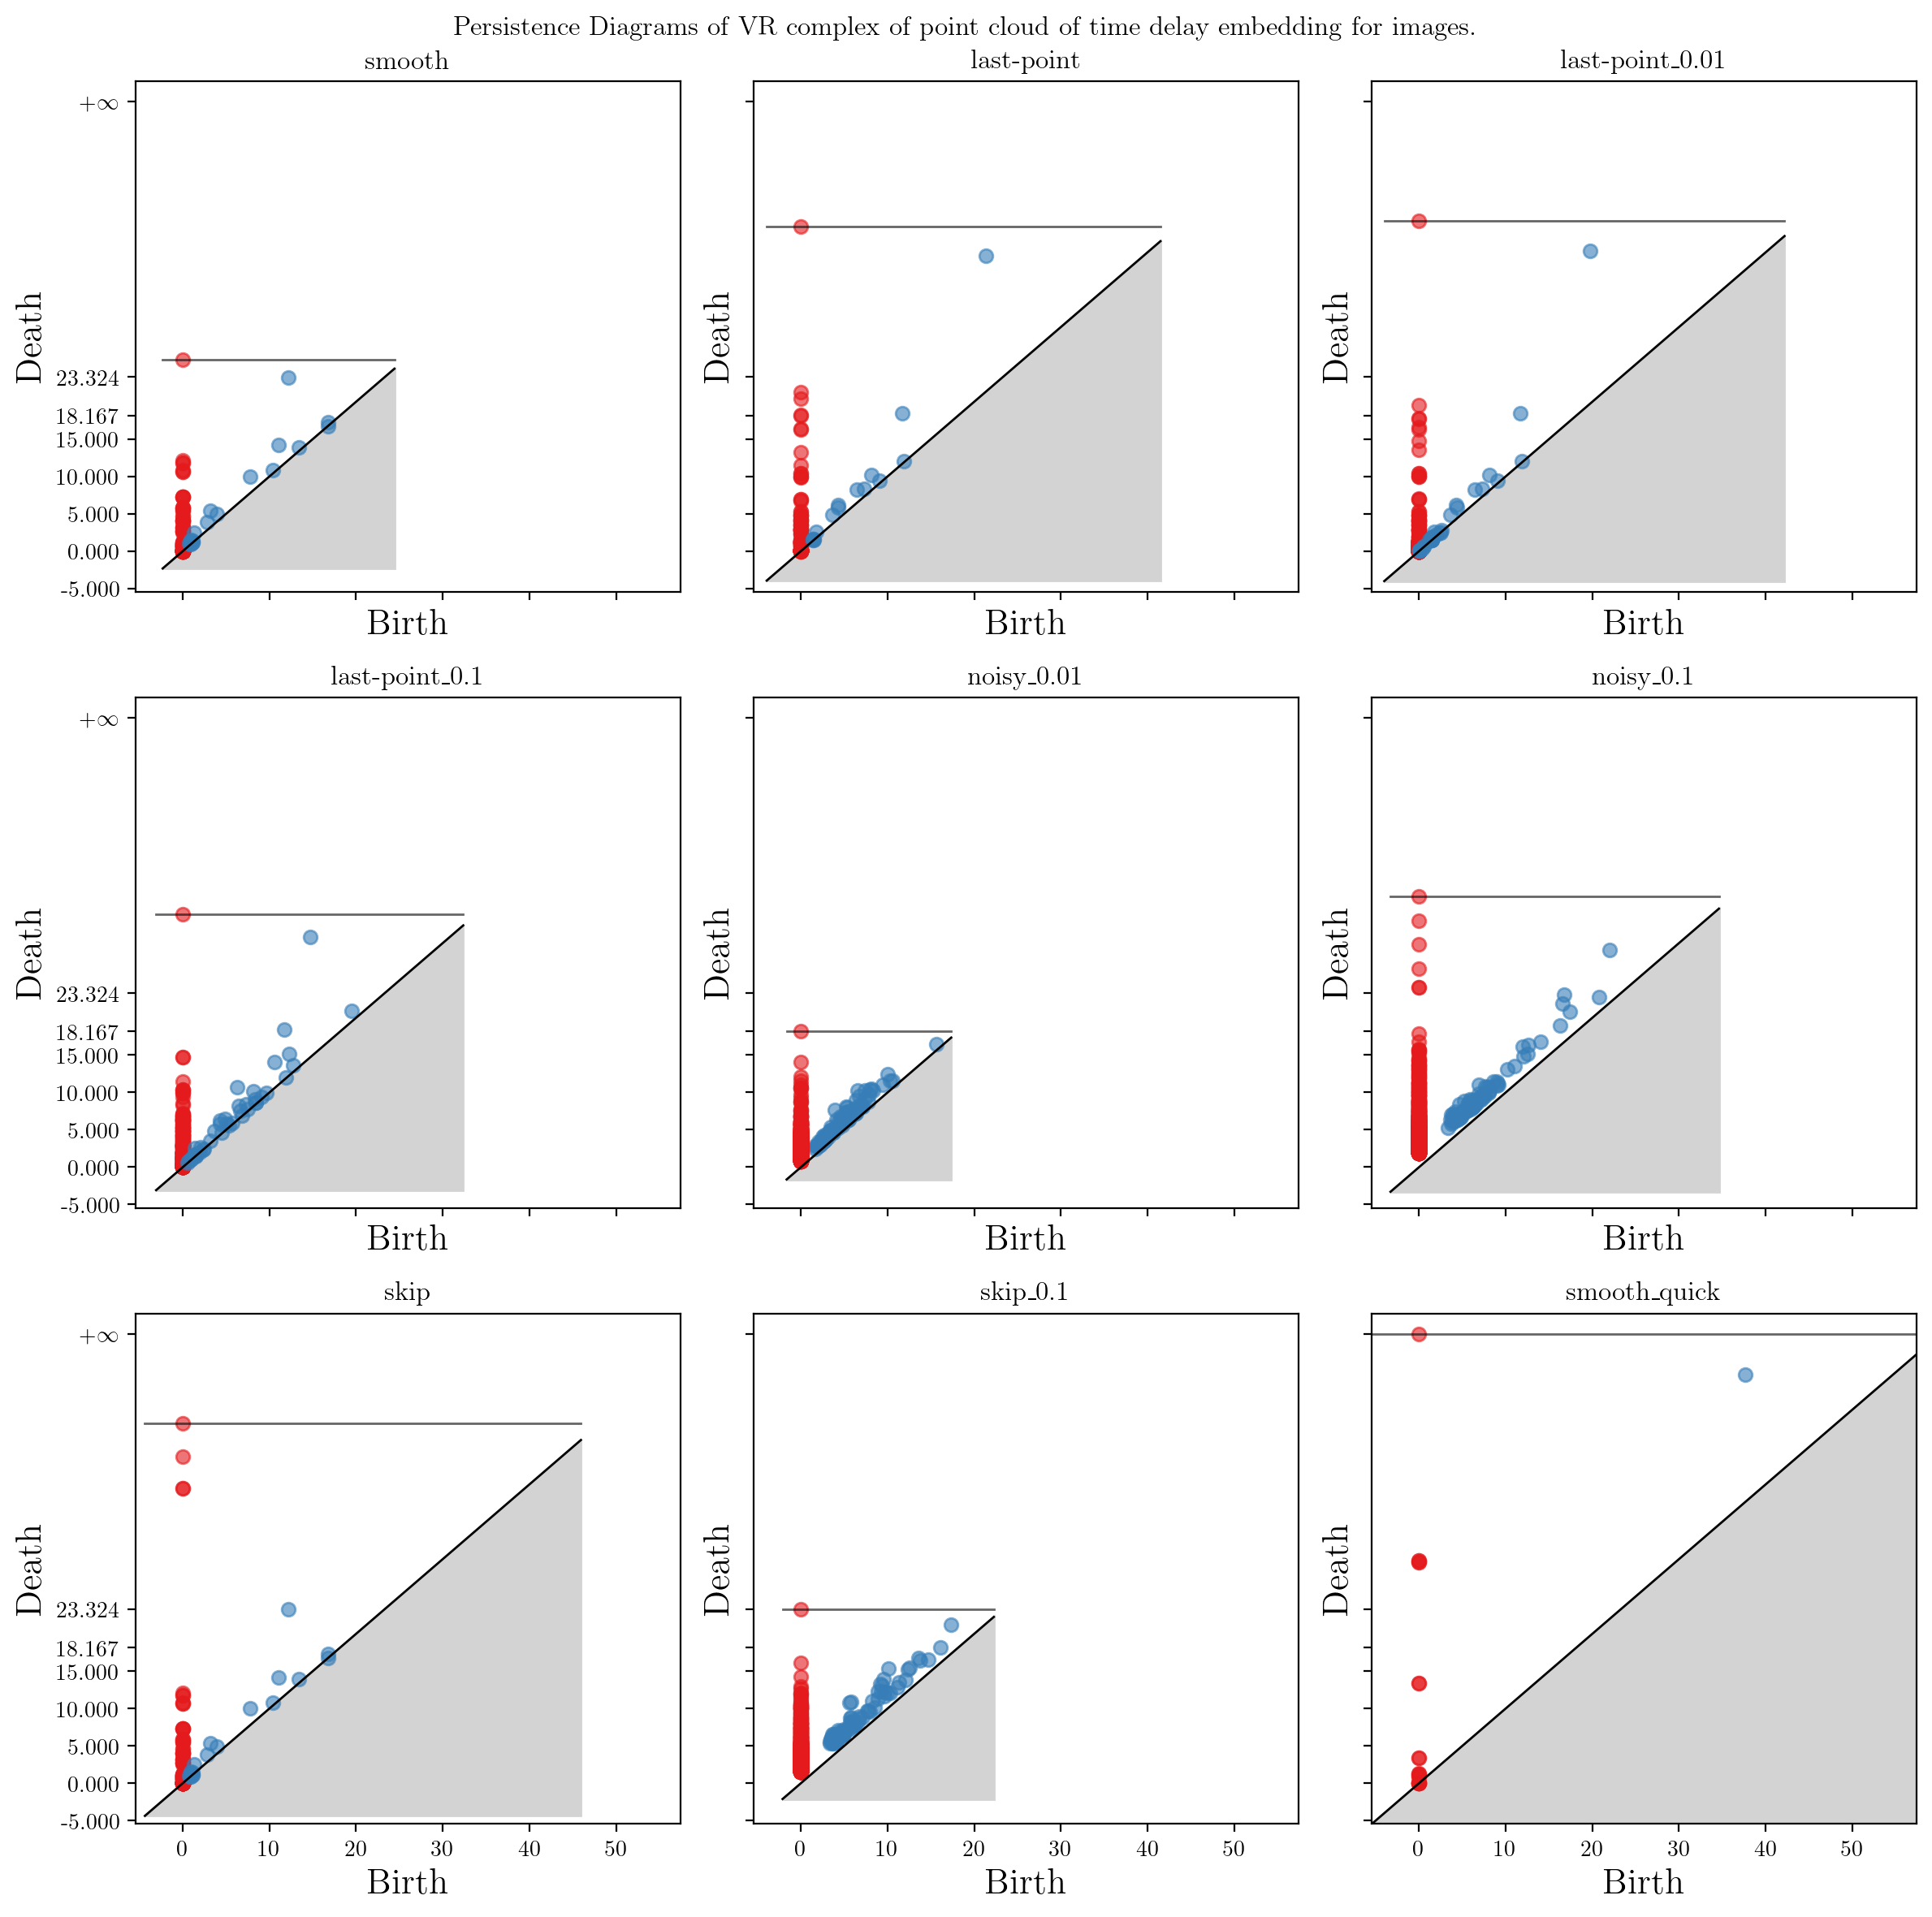

In [34]:
fig, ax_list = create_fig(samples_all, dpi=200, sharey=True, sharex=True)

diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
                                'images_consecutive_VRcomplex.npz'))

for i, key in enumerate(diagrams.keys()):
    dgmX = diagram_convert(diagrams[key])
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title('_'.join(key.split('_')[1:]))

for i in range(len(diagrams.keys()), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of VR complex of point cloud of time delay embedding for images.')
fig.tight_layout()
fig.savefig(os.path.join(data_folder, 'plots', 'img_VR_timedelay.png'))

In [35]:
## COMUPYTING TAKES TOO LONG RIGHT NOW!
# fig, ax_list = create_fig(samples_all[:2], dpi=200, sharey=True, sharex=True)

# diagrams = np.load(os.path.join(data_folder, 'persistence_diagrams', 
#                                 'images_distamtrix_VRcomplex.npz'))

# for i, key in enumerate(diagrams.keys()):
#     dgmX = diagram_convert(diagrams[key])
#     gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
#     ax_list[i].set_title(key)

# for i in range(len(diagrams.keys()), len(ax_list)):
#     ax_list[i].remove()

# fig.suptitle('Persistence Diagrams of vietoris rips complex'
#              + ' of distance point cloud.')
# fig.tight_layout()
# fig.savefig(os.path.join(data_folder, 'plots', 'img_VR_pwDistances.png'))

# Persistence Diagram differences

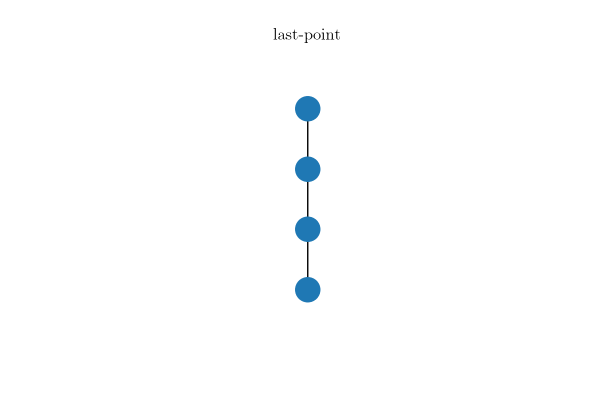

In [69]:
from IPython.display import Image
Image(open('./data_1000/animation/anim_images_last-point.gif','rb').read())

In [5]:
dirpath = os.path.join(data_folder, 'persistence_diagrams')

if os.path.isfile(os.path.join(dirpath, 'diagram_distances.csv')):
    print(f'File {os.path.join(dirpath, "diagram_distances.csv")} exists already!')
    print('Delete if you want to run calculations!')

else:
    # pbar = tqdm([x for x in os.listdir(dirpath) 
    #             if x.endswith('.npz')])

    for filename in [x for x in os.listdir(dirpath) if x.endswith('.npz')]:
        # pbar.set_description(f'{filename}')]

        if os.path.isfile(os.path.join(dirpath, f'diagram_distances_{filename[:-4]}.csv')):
            continue

        print(filename)

        diagrams = np.load(os.path.join(dirpath, filename))
        keys = list(diagrams.keys())

        if 'alphacomplex' in filename:
            pers_complex = 'alpha'
        elif 'VRcomplex' in filename:
            pers_complex = 'vietoris'
        else:
            raise ValueError('wrong filename? no complex info')

        if 'consecutive' in filename:
            embedding = 1
        elif 'distmatrix' in filename:
            embedding = 0
        else:
            raise ValueError('wrong filename? no complex info')

        if 'coords' in filename:
            point_diff = 'coords'
        elif 'images' in filename:
            point_diff = 'images'
        else:
            raise ValueError('wrong filename? no complex info')

        distances = []
        for dim in [0, 1, 2]:
            distances_dim = []
            if os.path.isfile(os.path.join(dirpath, f'diagram_distances_{filename[:-4]}_dim{dim}.csv')):
                continue

            print('  dim: ', dim)
            diags = [diagrams[key][diagrams[key][:, 2]==dim, :2] for key in diagrams.keys()]
            ds = DiagramSelector(use=True, point_type='finite').fit_transform(diags)

            if all([len(x)==0 for x in ds]):
                print(f' - empty persistence diagrams for dim={dim}!')
                continue
            
            print([len(diag) for diag in ds])

            resolution = 5000
            ls = Landscape(resolution=resolution).fit_transform(ds)
            ent = Entropy().fit_transform(ds)

            for i in tqdm(range(len(ds))):
                for j in range(i+1, len(ds)):
                    print(i, j)
                    dist = {'key_0': '_'.join(keys[i].split('_')[1:]),
                            'key_1': '_'.join(keys[j].split('_')[1:]),
                            'point_diff': point_diff,
                            'complex': pers_complex,
                            'embedding': embedding,
                            'dim': dim}
                    
                    print('bottle')
                    dist['bottleneck'] = bottleneck_distance(ds[i], ds[j])
                    print('wass')
                    dist['wasserstein'] = wasserstein_distance(ds[i], ds[j], order=2, internal_p=np.inf, delta=0.01)
                    print('land')
                    dist['landscape'] = np.mean([np.linalg.norm(ls[i][k*resolution:(k+1)*resolution]
                                                                -ls[j][k*resolution:(k+1)*resolution])
                                                 for k in range(len(ls[i])//resolution)])
                    print('entropy')
                    dist['entropy'] = np.linalg.norm(ent[i]-ent[j])

                    distances_dim.append(dist.copy())
    
            pd.DataFrame(distances_dim).to_csv(os.path.join(dirpath, f'diagram_distances_{filename[:-4]}_dim{dim}.csv'))
            distances.extend(distances_dim)

        pd.DataFrame(distances).to_csv(os.path.join(dirpath, f'diagram_distances_{filename[:-4]}_dim{dim}.csv'))    

coords_consecutive_VRcomplex.npz
  dim:  0
[896, 918, 921, 921, 997, 997, 908, 996, 965]


  0%|          | 0/9 [00:00<?, ?it/s]

0 1
bottle
wass
land
entropy
0 2
bottle
wass
land
entropy
0 3
bottle
wass
land
entropy
0 4
bottle
wass
land
entropy
0 5
bottle
wass
land
entropy
0 6
bottle
wass
land
entropy
0 7
bottle
wass
land
entropy
0 8
bottle
wass


 11%|█         | 1/9 [00:08<01:05,  8.21s/it]

land
entropy
1 2
bottle
wass
land
entropy
1 3
bottle
wass
land
entropy
1 4
bottle
wass
land
entropy
1 5
bottle
wass
land
entropy
1 6
bottle
wass
land
entropy
1 7
bottle
wass
land
entropy
1 8
bottle
wass


 22%|██▏       | 2/9 [00:20<01:14, 10.71s/it]

land
entropy
2 3
bottle
wass
land
entropy
2 4
bottle
wass
land
entropy
2 5
bottle
wass
land
entropy
2 6
bottle
wass
land
entropy
2 7
bottle
wass
land
entropy
2 8
bottle
wass


 33%|███▎      | 3/9 [00:27<00:54,  9.15s/it]

land
entropy
3 4
bottle
wass
land
entropy
3 5
bottle
wass
land
entropy
3 6
bottle
wass
land
entropy
3 7
bottle
wass
land
entropy
3 8
bottle
wass


 44%|████▍     | 4/9 [00:34<00:40,  8.06s/it]

land
entropy
4 5
bottle
wass
land
entropy
4 6
bottle
wass
land
entropy
4 7
bottle
wass
land
entropy
4 8
bottle
wass


 56%|█████▌    | 5/9 [00:38<00:25,  6.50s/it]

land
entropy
5 6
bottle
wass
land
entropy
5 7
bottle
wass
land
entropy
5 8
bottle
wass


 67%|██████▋   | 6/9 [00:40<00:15,  5.26s/it]

land
entropy
6 7
bottle
wass
land
entropy
6 8
bottle
wass


 78%|███████▊  | 7/9 [00:43<00:08,  4.28s/it]

land
entropy
7 8
bottle
wass


100%|██████████| 9/9 [00:44<00:00,  4.94s/it]

land
entropy
  dim:  1
[47, 54, 58, 73, 445, 516, 45, 467, 98]



  0%|          | 0/9 [00:00<?, ?it/s]

0 1
bottle
wass
land
entropy
0 2
bottle
wass
land
entropy
0 3
bottle
wass
land
entropy
0 4
bottle
wass
land
entropy
0 5
bottle
wass
land
entropy
0 6
bottle
wass


In [5]:
from gudhi.representations import SlicedWassersteinDistance

dirpath = os.path.join(data_folder, 'persistence_diagrams')
diagrams = np.load(os.path.join(dirpath, 'coords_consecutive_VRcomplex.npz'))

dim = 1
diags = [diagrams[key][diagrams[key][:, 2]==dim, :2] for key in diagrams.keys()]
ds = DiagramSelector(use=True, point_type='finite').fit_transform(diags)



array([[0.00000000e+00, 3.51577817e-02, 2.85107188e-02, 2.19764308e-01,
        1.92775948e-01, 9.21333126e-01, 1.46619518e-14, 6.79218244e-01,
        7.53316513e-02],
       [3.51577817e-02, 0.00000000e+00, 2.40828554e-02, 2.12437602e-01,
        2.12330302e-01, 9.44509549e-01, 3.51577817e-02, 7.11345615e-01,
        6.81152447e-02],
       [2.85107188e-02, 2.40828554e-02, 0.00000000e+00, 2.17643426e-01,
        1.98454185e-01, 9.41594511e-01, 2.85107188e-02, 7.02816986e-01,
        7.99701119e-02],
       [2.19764308e-01, 2.12437602e-01, 2.17643426e-01, 0.00000000e+00,
        3.95105825e-01, 1.06507056e+00, 2.19764308e-01, 8.53079055e-01,
        2.12417337e-01],
       [1.92775948e-01, 2.12330302e-01, 1.98454185e-01, 3.95105825e-01,
        0.00000000e+00, 1.07199633e+00, 1.92775948e-01, 8.23405050e-01,
        2.62270750e-01],
       [9.21333126e-01, 9.44509549e-01, 9.41594511e-01, 1.06507056e+00,
        1.07199633e+00, 0.00000000e+00, 9.21333126e-01, 4.75352855e-01,
        9.8

In [8]:
dirpath = os.path.join(data_folder, 'persistence_diagrams')

if os.path.isfile(os.path.join(dirpath, 'diagram_distances.csv')):
    print(f'File {os.path.join(dirpath, "diagram_distances.csv")} exists already!')
    print('Delete if you want to run calculations!')

else:
    # pbar = tqdm([x for x in os.listdir(dirpath) 
    #             if x.endswith('.npz')])
    distances = []
    for filename in [x for x in os.listdir(dirpath) if x.endswith('.npz')]:
        # pbar.set_description(f'{filename}')]

        if os.path.isfile(os.path.join(dirpath, f'diagram_distances_{filename[:-4]}.csv')):
            continue

        print(filename)

        diagrams = np.load(os.path.join(dirpath, filename))
        keys = list(diagrams.keys())

        if 'alphacomplex' in filename:
            pers_complex = 'alpha'
        elif 'VRcomplex' in filename:
            pers_complex = 'vietoris'
        else:
            raise ValueError('wrong filename? no complex info')

        if 'consecutive' in filename:
            embedding = 1
        elif 'distmatrix' in filename:
            embedding = 0
        else:
            raise ValueError('wrong filename? no complex info')

        if 'coords' in filename:
            point_diff = 'coords'
        elif 'images' in filename:
            point_diff = 'images'
        else:
            raise ValueError('wrong filename? no complex info')

        # distances = []
        for dim in [0, 1, 2]:
            # distances_dim = []
            if os.path.isfile(os.path.join(dirpath, f'diagram_distances_{filename[:-4]}_dim{dim}.csv')):
                continue

            print('  dim: ', dim)
            diags = [diagrams[key][diagrams[key][:, 2]==dim, :2] for key in diagrams.keys()]
            ds = DiagramSelector(use=True, point_type='finite').fit_transform(diags)

            if all([len(x)==0 for x in ds]):
                print(f' - empty persistence diagrams for dim={dim}!')
                continue
            
            # print([len(diag) for diag in ds])

            resolution = 5000
            ls = Landscape(resolution=resolution).fit_transform(ds)
            ent = Entropy().fit_transform(ds)

            # use Wasserstein approximation
            sliced_was = SlicedWassersteinDistance(n_jobs=-1).fit_transform(ds)

            for i in tqdm(range(len(ds))):
                for j in range(i+1, len(ds)):
                    # print(i, j)
                    dist = {'key_0': '_'.join(keys[i].split('_')[1:]),
                            'key_1': '_'.join(keys[j].split('_')[1:]),
                            'point_diff': point_diff,
                            'complex': pers_complex,
                            'embedding': embedding,
                            'dim': dim}
                    
                    dist['bottleneck'] = bottleneck_distance(ds[i], ds[j])
                    # wasserstein hangs up at one point! 
                    # namely for 'coords_consecutive_VRcomplex.npz' and dim=1
                    # dist['wasserstein'] = wasserstein_distance(ds[i], ds[j], order=2, internal_p=np.inf, delta=0.01)
                    dist['wasserstein'] = sliced_was[i][j]
                    dist['landscape'] = np.mean([np.linalg.norm(ls[i][k*resolution:(k+1)*resolution]
                                                                -ls[j][k*resolution:(k+1)*resolution])
                                                 for k in range(len(ls[i])//resolution)])
                    dist['entropy'] = np.linalg.norm(ent[i]-ent[j])

                    distances.append(dist.copy())
    
            # pd.DataFrame(distances_dim).to_csv(os.path.join(dirpath, f'diagram_distances_{filename[:-4]}_dim{dim}.csv'))
            # distances.extend(distances_dim)

pd.DataFrame(distances).to_csv(os.path.join(dirpath, f'diagram_distances.csv'))  

coords_consecutive_alphacomplex.npz
  dim:  0


100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


  dim:  1


100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


  dim:  2


100%|██████████| 9/9 [00:01<00:00,  8.82it/s]


coords_consecutive_VRcomplex.npz
  dim:  0


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


  dim:  1


100%|██████████| 9/9 [00:00<00:00, 27.25it/s]


  dim:  2
 - empty persistence diagrams for dim=2!
coords_distmatrix_VRcomplex.npz
  dim:  0


100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


  dim:  1


100%|██████████| 9/9 [00:00<00:00, 59.16it/s]


  dim:  2
 - empty persistence diagrams for dim=2!
images_consecutive_alphacomplex.npz
  dim:  0


100%|██████████| 9/9 [00:00<00:00, 12.49it/s]


  dim:  1


100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


  dim:  2


100%|██████████| 9/9 [00:00<00:00, 15.14it/s]


images_consecutive_VRcomplex.npz
  dim:  0


100%|██████████| 9/9 [00:00<00:00, 13.71it/s]


  dim:  1


100%|██████████| 9/9 [00:00<00:00, 23.73it/s]

  dim:  2
 - empty persistence diagrams for dim=2!


In [ ]:
# dirpath = os.path.join(data_folder, 'persistence_diagrams')

# if os.path.isfile(os.path.join(dirpath, 'diagram_distances.csv')):
#     print(f'File {os.path.join(dirpath, "diagram_distances.csv")} exists already!')
#     print('Delete if you want to run calculations!')

# else:
#     distances = []
#     # pbar = tqdm([x for x in os.listdir(dirpath) 
#     #             if x.endswith('.npz')])

#     for filename in [x for x in os.listdir(dirpath) if x.endswith('.npz')]:
#         filepath = os.path.join(dirpath, f'diagram_distances_{filename[:-4]}.csv')
#         if os.path.isfile(filepath):
#             distances.append(pd.read_csv(filepath))
#         else:
#             raise FileExistsError(f'{filepath} Does not exist!')

In [9]:
df_dist = pd.read_csv(os.path.join(dirpath, 'diagram_distances.csv'))

value_text = {'bottleneck': 'Bottleneck distance',
              'wasserstein': 'Wasserstein distance',
              'landscape': 'L^2 distance of landscapes',
              'entropy': 'absolute difference between entropy'
             }

combs_idx = ['point_diff', 'complex', 'embedding']
combs = df_dist.set_index(combs_idx).index.unique()
combs

# make it so that 'smooth' is the first in the keys list
keys = list(np.unique(np.stack([df_dist['key_0'], df_dist['key_1']])))
if 'smooth' in keys:
    keys.remove('smooth')
    keys.insert(0, 'smooth')

In [10]:
# example

df = df_dist.loc[(df_dist['point_diff']=='coords') & (df_dist['embedding']==1) & (df_dist['complex']=='alpha')]
df = df.pivot_table(values="bottleneck", index="key_0", columns="key_1", aggfunc=np.linalg.norm)

# make into a proper distance matix and sort the columns
new_col = set(df.index).difference(set(df.columns)).pop()
df.loc[:, new_col] = df.loc[new_col]

new_idx = set(df.columns).difference(set(df.index)).pop()
df.loc[new_idx] = df.loc[:, new_idx]

df = df.loc[keys, keys]

# fill out all entries
for j in range(len(keys)):
    for i in range(j, len(keys)):
        if i == j:
            df.loc[keys[i], keys[i]] = 0
        else:
            df.loc[keys[i], keys[j]] = df.loc[keys[j], keys[i]]

df

key_1              smooth  last-point  last-point_0.01  last-point_0.1  \
key_0                                                                    
smooth           0.000000    0.008269         0.007755        0.005979   
last-point       0.008269    0.000000         0.003561        0.008890   
last-point_0.01  0.007755    0.003561         0.000000        0.008934   
last-point_0.1   0.005979    0.008890         0.008934        0.000000   
noisy_0.01       0.000025    0.008269         0.007755        0.005979   
noisy_0.1        0.000572    0.008269         0.007756        0.005979   
skip             0.000167    0.008269         0.007755        0.005979   
skip_0.1         0.000465    0.008269         0.007756        0.005979   
smooth_quick     0.008649    0.010520         0.010557        0.008427   

key_1            noisy_0.01  noisy_0.1      skip  skip_0.1  smooth_quick  
key_0                                                                     
smooth             0.000025   0.000572  0.000167  0.000465      0.008649  
last-point         0.008269   0.008269  0.008269  0.008269      0.010520  
last-point_0.01    0.007755   0.007756  0.007755  0.007756      0.010557  
last-point_0.1     0.005979   0.005979  0.005979  0.005979      0.008427  
noisy_0.01         0.000000   0.000572  0.000168  0.000465      0.008649  
noisy_0.1          0.000572   0.000000  0.000572  0.000373      0.008650  
skip               0.000168   0.000572  0.000000  0.000465      0.008649  
skip_0.1           0.000465   0.000373  0.000465  0.000000      0.008650  
smooth_quick       0.008649   0.008650  0.008649  0.008650      0.000000

In [15]:
for unique_combs in combs:
    df_combs = df_dist.loc[(df_dist['point_diff']==unique_combs[0])
                         & (df_dist['complex']==unique_combs[1])
                         & (df_dist['embedding']==unique_combs[2])]
    if len(df_combs) == 0:
        print(unique_combs, 'empty')
        continue

    fig, ax = plt.subplots(2, 2, dpi=100, figsize=(20,20))
    for key_i, key in enumerate(value_text):
        axi = ax[np.unravel_index(key_i, [2, 2])]

        df = df_combs.pivot_table(values=key,
                                  index="key_0",
                                  columns="key_1",
                                  aggfunc=np.linalg.norm)

        # make into a proper distance matix and sort the columns
        new_col = set(df.index).difference(set(df.columns)).pop()
        df.loc[:, new_col] = df.loc[new_col]

        new_idx = set(df.columns).difference(set(df.index)).pop()
        df.loc[new_idx] = df.loc[:, new_idx]

        df = df.loc[keys, keys]

        # fill out all entries
        for j in range(len(keys)):
            for i in range(j, len(keys)):
                if i == j:
                    df.loc[keys[i], keys[i]] = None
                else:
                    df.loc[keys[i], keys[j]] = df.loc[keys[j], keys[i]]

        # now plot it with reverse color map
        sns.heatmap(df, ax=axi, cmap=sns.cm.rocket_r)

        axi.set_xlabel('')
        axi.set_ylabel('')

        axi.set_title(value_text[key])

    fig.suptitle(f'distance between {unique_combs[0]}, complex: {unique_combs[1]}, embedding: {unique_combs[2]}')
    fig.tight_layout()
    
    fig.savefig(f'./{data_folder}/plots/distances_persistence_diagram_{unique_combs[0]}_{unique_combs[1]}_{unique_combs[2]}.png')
    plt.close(fig)

ASSUME THAT WE HAVE AT MOST 6 different combinations of inputs for persistence diagrams

In [339]:
# # check for one entry

# col_groupby = ['key_0', 'key_1', 'point_diff', 'complex', 'embedding']
# df_norm = df_dist.groupby(by=col_groupby)[['bottleneck']].apply(np.linalg.norm).reset_index()
# df_norm = df_norm.rename(columns={0: 'bottleneck'})

# combs_idx = ['point_diff', 'complex', 'embedding']
# combs = df_dist.set_index(combs_idx).index.unique()

# print(np.linalg.norm(df_dist.loc[(df_dist['key_0']=='smooth') & (df_dist['key_1']=='smooth_quick') & (df_dist['point_diff']=='coords') & (df_dist['embedding']==1) & (df_dist['complex']=='alpha'), 'bottleneck']))

# print('vs')

# print(df_norm.loc[(df_norm['key_0']=='smooth') & (df_norm['key_1']=='smooth_quick') & (df_norm['point_diff']=='coords') & (df_norm['embedding']==1) & (df_norm['complex']=='alpha')])

# df.loc['smooth', 'smooth_quick']

0.008649126694157473
vs
      key_0         key_1 point_diff complex  embedding  bottleneck
175  smooth  smooth_quick     coords   alpha          1    0.008649


0.008649126694157473